In [5]:
# add path to sispeuede to sys.path in python
import sys
import warnings
dir_git = "/Users/usuario/git/sisepuede"
if dir_git not in sys.path:
    sys.path.append(dir_git)


warnings.filterwarnings("ignore")

import logging
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import sisepuede as si
import sisepuede.core.attribute_table as att
import sisepuede.core.model_attributes as ma
import sisepuede.core.model_variable as mv
import sisepuede.core.support_classes as sc
import sisepuede.manager.sisepuede_examples as sxm
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.visualization.plots as svp
import sisepuede.transformers as trf
import sisepuede.utilities._toolbox as sf
import sisepuede.utilities._sql as squ
import sqlalchemy
import time
from typing import *

# hack for now
log_job = None



# Setup the file structure and read in data

In [6]:
importlib.reload(sfs.ma)
importlib.reload(sfs)
struct = sfs.SISEPUEDEFileStructure()
examples = sxm.SISEPUEDEExamples()

matt = struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

# directories
path_cur = pathlib.Path(os.getcwd())
path_data = path_cur.joinpath("data")
path_transformations = path_cur.joinpath("transformations")
if not path_transformations.exists():
    path_transformations.mkdir(exist_ok = True, )

# file paths
fp_inputs = path_data.joinpath("louisiana_inputs_raw.csv")#joinpath("louisiana_working_data_20240826", "MODEL_INPUTS.csv")



# Some calibration--move to "build_data"
- Adjust demands
- Shift hydropower out of MSP and make cost high--we don't want new Hydropower being built
- Make Nuclear very expensive as well

In [230]:
df_input = pd.read_csv(fp_inputs, )



# some categories
_CAT_ENTC_HYDROPOWER = "pp_hydropower"
_CAT_ENTC_NUCLEAR = "pp_nuclear"

# some model variables
_MODVAR_AFS = matt.get_variable("NemoMod AvailabilityFactor Scalar")
_MODVAR_COST_CAP = matt.get_variable("NemoMod CapitalCost")
_MODVAR_COST_CAP_STORAGE = matt.get_variable("NemoMod CapitalCostStorage")
_MODVAR_IAR = matt.get_variable("Fuel Production NemoMod InputActivityRatio Electricity")
_MODVAR_RE_TAG = matt.get_variable("NemoMod RETagTechnology")
_MODVAR_TMIC_STORAGE = matt.get_variable("NemoMod TotalAnnualMaxCapacityInvestmentStorage")

_MODVAR_IC_SCOE_E_APP = matt.get_variable("SCOE Initial Per GDP Electric Appliances Energy Consumption")
_MODVAR_IC_SCOE_E_HEA = matt.get_variable("SCOE Initial Per GDP Heat Energy Consumption")
_MODVAR_IC_SCOE_E_HH_APP = matt.get_variable("SCOE Initial Per Household Electric Appliances Energy Consumption")
_MODVAR_IC_SCOE_E_HH_HEA = matt.get_variable("SCOE Initial Per Household Heat Energy Consumption")



"""
# LEGACY CODE TO HOLD

for cat in ["hydropower"]:

    df_input[f"nemomod_entc_capital_cost_pp_{cat}_mm_usd_per_gw"] *= 20
    #df_input[f"nemomod_entc_frac_min_share_production_pp_{cat}"] = 0.0
    # df_input[f"nemomod_entc_total_annual_max_capacity_investment_pp_{cat}_gw"] = 0.0
    # df_input[f"nemomod_entc_fixed_cost_pp_{cat}_per_gw"] *= 20
    # df_input[f"nemomod_entc_variable_cost_pp_{cat}_per_mwh"] *= 20    
    # if cat != "nuclear": continue
    # df_input[f"nemomod_entc_residual_capacity_pp_{cat}_gw"] = df_input[f"nemomod_entc_residual_capacity_pp_{cat}_gw"].iloc[0]
"""


##  SET RENEWABLE TAG FOR NUCLEAR

df_input["nemomod_entc_renewable_energy_tag_pp_nuclear"] = 1.0



##  ADJUST CAPITAL COSTS TO USE AS CONSTRAINT

# adjust hydro
field_cc_hydropower = _MODVAR_COST_CAP.build_fields(category_restrictions = _CAT_ENTC_HYDROPOWER, )
df_input[field_cc_hydropower] *= 20

# adjust nuclear
field_cc_nuclear = _MODVAR_COST_CAP.build_fields(category_restrictions = _CAT_ENTC_NUCLEAR, )
df_input[field_cc_nuclear] *= 10



##  INCREASE PRICE OF STORAGE TYPES

fields_scale_up = _MODVAR_COST_CAP_STORAGE.build_fields(
    category_restrictions = ["st_pumped_hydro", "st_compressed_air"]
)
df_input[fields_scale_up] *= 10

# cap storage in first 12 years (2015-)
fields_tmic_storage = _MODVAR_TMIC_STORAGE.fields
for field in fields_tmic_storage:
    df_input[field].iloc[0:12] = 0



#####################
#    CALIBRATION    #
#####################

##  Reduce me_crude electricity requirement, which was driving high electricity

# 4.8 is the closest calibrated value, we up to 5 to give some headroom in solutions
field_crude_calib = _MODVAR_IAR.build_fields(
    category_restrictions = "me_crude"
)
df_input[field_crude_calib] /= 5



##  REDUCE INITIAL CONSUMPTION IN SCOE

fields_scale_down_scoe = sum(
    [
        _MODVAR_IC_SCOE_E_APP.fields,
        _MODVAR_IC_SCOE_E_HEA.fields,
        _MODVAR_IC_SCOE_E_HH_APP.fields,
        _MODVAR_IC_SCOE_E_HH_HEA.fields
    ],
    []
)
# reduce initial scoe energy consumption by 6.5% (closest match) v 10% (support model run)
# - 93.5% is the "calibrated" value; we reduce a little bit more to prevent new capital
df_input[fields_scale_down_scoe] *= 0.9 



# MAKE SURE THERE'S NO CAP TO PREVENT INFEASIBILITY
fields_try_to_cap = [x for x in df_input.columns if "nemomod_entc_total_annual_max_capacity_investment_pp_" in x]
for field in fields_try_to_cap:
    #df_6004[field].iloc[0:10] = 0
    df_input[field] = -999



# ADJUST THE AVAILABILITY FACTOR

groups_afs_scale = [
    (
        [
            "pp_gas",
            "pp_gas_ccs",
            "pp_coal",
            "pp_coal_ccs",
            "pp_oil"
        ],
        0.9/0.8
    ),

    (
        [
            "pp_nuclear"
        ],
        0.92/0.9,
    ),

    (
        [
            "pp_biomass"
        ],
        0.9/0.7,
    ),

    (
        [
            "pp_solar"
        ],
        0.9/0.74538503,
    ),

    (
        [
            "pp_biogas",
            "pp_waste_incineration"
        ],
        0.85/0.7,
    )
]


# scale up
for group in groups_afs_scale:
    cats, scale = group
    fields = _MODVAR_AFS.build_fields(
        category_restrictions = cats,
    )
    df_input[fields] *= scale
    



"""
df_input = pd.read_csv(path_data.joinpath("louisiana_inputs_raw.csv"))

cost_inf = 1e+20

for cat in ["hydropower"]:
    #df_input[f"nemomod_entc_frac_min_share_production_pp_{cat}"] = 0.0
    # df_input[f"nemomod_entc_total_annual_max_capacity_investment_pp_{cat}_gw"] = 0.0
    df_input[f"nemomod_entc_capital_cost_pp_{cat}_mm_usd_per_gw"] *= 20
    # df_input[f"nemomod_entc_fixed_cost_pp_{cat}_per_gw"] *= 20
    # df_input[f"nemomod_entc_variable_cost_pp_{cat}_per_mwh"] *= 20    
    # if cat != "nuclear": continue
    # df_input[f"nemomod_entc_residual_capacity_pp_{cat}_gw"] = df_input[f"nemomod_entc_residual_capacity_pp_{cat}_gw"].iloc[0]

# set nuclear as a renewable tech
df_input["nemomod_entc_renewable_energy_tag_pp_nuclear"] = 1.0
df_input["nemomod_entc_capital_cost_pp_nuclear_mm_usd_per_gw"] *= 10

# some storage caps
# df_input["nemomod_enst_total_annual_max_capacity_st_pumped_hydro_pj"] = 0.0
df_input["nemomod_enst_capital_cost_st_pumped_hydro_usd_per_kwh"] *= 10
df_input["nemomod_enst_capital_cost_st_compressed_air_usd_per_kwh"] *= 10
#df_input["nemomod_enst_total_annual_max_capacity_st_pumped_hydro_pj"] *= 0


##  CALIBRATED! Reduced me crude electricity requirement, which was driving high electricity

for k in [
    "nemomod_entc_input_activity_ratio_fuel_production_me_crude_electricity",
    #"nemomod_entc_input_activity_ratio_fuel_production_fp_ammonia_production_electricity"
]:
    
    df_input[k] /= 5  # 4.8 is the closest calibrated value, we up to 5


# reduce initial scoe energy consumption by 6.5% (closest match) v 10% (support model run)
fields_scale_down = [x for x in df_input if "consumpinit_scoe_" in x]
for x in fields_scale_down:
    df_input[x] *= 0.9 ##  93.5% is the "calibrated" value; we reduce a little bit more to prevent new capital





# TRY CAPPING
fields_try_to_cap = [x for x in df_input.columns if "nemomod_entc_total_annual_max_capacity_investment_pp_" in x]
for field in fields_try_to_cap:
    #df_6004[field].iloc[0:10] = 0
    df_input[field] = -999



# ADJUST THE AVAILABILITY FACTOR

modvar_afs = matt.get_variable("NemoMod AvailabilityFactor Scalar")

# thermal
fields_scale_up = modvar_afs.build_fields(
    category_restrictions = [
        "pp_gas",
        "pp_gas_ccs",
        "pp_coal",
        "pp_coal_ccs",
        "pp_oil"
    ]
)
for field in fields_scale_up:
    df_input[field] = 0.9/0.36

# nuclear
fields_scale_up = modvar_afs.build_fields(
    category_restrictions = [
        "pp_nuclear"
    ]
)
for field in fields_scale_up:
    df_input[field] = 0.92/0.8

# biomass
fields_scale_up = modvar_afs.build_fields(
    category_restrictions = [
        "pp_biomass"
    ]
)
for field in fields_scale_up:
    df_input[field] = 0.9/0.37

# solar
fields_scale_up = modvar_afs.build_fields(
    category_restrictions = [
        "pp_solar"
    ]
)
for field in fields_scale_up:
    df_input[field] = 0.9/0.74538503

# biogas and waste incineration
fields_scale_up = modvar_afs.build_fields(
    category_restrictions = [
        "pp_biogas",
        "pp_waste_incineration"
    ]
)
for field in fields_scale_up:
    df_input[field] = 0.85/0.5

""";



In [231]:
models.model_afolu.project(df_input)

,time_period,frac_area_cropland_calculated_bevs_and_spices,frac_area_cropland_calculated_cereals,frac_area_cropland_calculated_fibers,frac_area_cropland_calculated_fruits,frac_area_cropland_calculated_herbs_and_other_perennial_crops,frac_area_cropland_calculated_nuts,frac_area_cropland_calculated_other_annual,frac_area_cropland_calculated_other_woody_perennial,frac_area_cropland_calculated_pulses,...,emission_co2e_co2_soil_lime_use,emission_co2e_co2_soil_urea_use,demand_soil_lime_kt,demand_soil_urea_kt,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_soil
0,0,0.0,0.163562,0.030331,0.000036,0.035202,0.002985,0.513194,0.0,0.000159,...,0.011205,0.087350,22.000000,119.114278,1.584478,-19.958559,16.469581,0.284571,1.240654,1.824732
1,1,0.0,0.163562,0.030331,0.000036,0.035202,0.002985,0.513194,0.0,0.000159,...,0.011143,0.095410,21.877301,130.104404,1.589763,-21.109438,16.426504,0.282339,1.232015,1.843454
2,2,0.0,0.163562,0.030331,0.000036,0.035202,0.002985,0.513194,0.0,0.000159,...,0.011080,0.089783,21.755315,122.431052,1.681750,-14.394049,24.697164,0.281897,1.223372,1.856844
3,3,0.0,0.163562,0.030331,0.000036,0.035202,0.002985,0.513194,0.0,0.000159,...,0.011004,0.091338,21.604939,124.551166,1.570329,-7.905364,14.561098,0.279322,1.196537,1.854702
4,4,0.0,0.163562,0.030331,0.000036,0.035202,0.002985,0.513194,0.0,0.000159,...,0.010943,0.085861,21.484753,117.082670,1.549010,-33.457072,19.479476,0.278885,1.185120,1.852629
5,5,0.0,0.163562,0.030331,0.000036,0.035202,0.002985,0.513194,0.0,0.000159,...,0.010876,0.085068,21.354282,116.002172,1.553185,-28.953986,19.483242,0.277366,1.167236,1.855913
6,6,0.0,0.163562,0.030331,0.000036,0.035202,0.002985,0.513194,0.0,0.000159,...,0.010810,0.084299,21.224830,114.953087,1.558132,-10.056567,19.486866,0.275789,1.149638,1.856279
7,7,0.0,0.163562,0.030331,0.000036,0.035202,0.002985,0.513194,0.0,0.000159,...,0.010745,0.083528,21.096387,113.901592,1.544621,-11.396965,19.489811,0.274286,1.132313,1.852833
8,8,0.0,0.163562,0.030331,0.000036,0.035202,0.002985,0.513194,0.0,0.000159,...,0.010680,0.082750,20.968943,112.841523,1.514496,-12.389456,19.492091,0.272881,1.115261,1.844234
9,9,0.0,0.163562,0.030331,0.000036,0.035202,0.002985,0.513194,0.0,0.000159,...,0.010615,0.081968,20.842488,111.773991,1.537851,-13.154913,19.493722,0.271574,1.098474,1.829117


In [16]:
df_out = models.project(
    df_input.iloc[0:12],
    include_electricity_in_energy = True,
    #models_run = ["af", "ce", "ip"],
    time_periods_base = np.arange(12),
)


2025-19-Sep 22:58:37.299 Opened SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-19-Sep 22:58:37.437 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-19-Sep 22:58:52.057 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-19-Sep 22:58:52.524 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-19-Sep 22:59:10.769 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


In [492]:
df_out


0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
211    0.0
212    0.0
213    0.0
214    0.0
215    0.0
Name: energy_demand_inen_cement, Length: 216, dtype: float64

In [81]:
modvar_ved = matt.get_variable("Gravimetric Energy Density")
modvar_ved.get_from_dataframe(df_input)
#[x for x in df_input.columns if ("ef_" in x) and ("biomass" in x)]
#df_input["ef_enfu_combustion_tonne_co2_per_tj_fuel_biomass"]

ged = df_input["energydensity_gravimetric_enfu_gj_per_tonne_fuel_biomass"].iloc[0]
ef_combustion = df_input["ef_enfu_combustion_tonne_co2_per_tj_fuel_biomass"].iloc[0]
ef_combustion_tonne_per_gj = ef_combustion/1000


tonne_co2_per_tonne_biomass = ef_combustion_tonne_per_gj*ged
tonne_co2_per_tonne_biomass

#
c_to_co2 = 11/3
c_to_co2/2      # about half of wood is carbon


1.8333333333333333

In [ ]:
def convert_biomass_emissions_to_c_equivalent_tonnes(
    emissions_co2_config: float,
) -> float:
    """Convert an emissions in config units to c equivalent in tonnes
    """

    # convert co2e 

## Get a `SISEPUEDEModels` object to use

In [9]:
import sqlalchemy
importlib.reload(sm)
importlib.reload(sm.mec)
importlib.reload(sm.mep)
importlib.reload(sm)
models = sm.SISEPUEDEModels(
    matt,
    allow_electricity_run = True,
    fp_julia = struct.dir_jl,
    fp_nemomod_reference_files = struct.dir_ref_nemo,
    fp_nemomod_temp_sqlite_db = struct.fp_sqlite_tmp_nemomod_intermediate,
    initialize_julia = True,
)

models.model_enerprod.solver_time_limit = 360


def get_engine(
) -> sqlalchemy.engine.Engine:
    """Get the engine associated with the model
    """
    engine = sqlalchemy.create_engine(f"sqlite:///{struct.fp_sqlite_tmp_nemomod_intermediate}")
    return engine
    

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1310.0 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


In [95]:

strat_6006 = strategies.get_strategy(6006)
df_6006 = strat_6006()
df_out_6006 = models.project(
    df_6006,
    regions = ["louisiana"],
    include_electricity_in_energy = False, 
    time_periods_base = np.arange(12),
    verbose = True,
);



NameError: name 'strategies' is not defined

In [59]:
strat.name

'TWI energy Subsector Industry'

In [64]:
"""_CODE_APPENDAGE = "_MIDINTENS"

strat_new = max(strategies.all_strategies) + 1
i = 0
rows = []

for strat_num in range(6008, strat_new):
    strat = strategies.get_strategy(strat_num, )

    transformation_list = strat.get_transformation_list(
        strat.transformation_specification,
        transformations,
    )

    new_list = []
    for transformation in transformation_list:
        code_check = f"{transformation.code}{_CODE_APPENDAGE}"
        out = (
            code_check
            if code_check in transformations.all_transformation_codes
            else transformation.code
        )

        new_list.append(out)
        

    # build rows
    rows.append(
        [
            strat_new + i,
            f"{strat.code}{_CODE_APPENDAGE}",
            f"{strat.name} implemented at medium intensity",
            f"Medium intensity implementation of {strat.name}",
            "|".join(sorted(new_list)),
            0
        ]
    )

    i += 1


strat_component_new = pd.DataFrame(rows, columns = strategies.attribute_table.table.columns)
strat_table_new = sf._concat_df(
    [
        strategies.attribute_table.table,
        strat_component_new
    ]
)

strat_table_new.to_csv(
    strategies.path_strategy_definition,
    index = None,
    encoding = "UTF-8",
)
"""

In [403]:
df_print = df_out_6004[[x for x in df_out_6004.columns if ("emission_" in x) and ("ippu" in x)]].iloc[0:1]
(
    df_print
    .transpose()
    .reset_index()
    .rename(
        columns = {
            0: "emission_co2e",
            "index": "field",
        }
    )
    .sort_values(
        ascending = False,
        by = ["emission_co2e"],
    )
    .reset_index(drop = True, )
)


,field,emission_co2e
0,emission_co2e_subsector_total_ippu,92.323613
1,emission_co2e_n2o_ippu_production_chemicals,59.110530
2,emission_co2e_co2_ippu_production_plastic,21.294033
3,emission_co2e_co2_ippu_production_chemicals,4.913317
4,emission_co2e_ch4_ippu_production_plastic,1.638218
...,...,...
86,emission_co2e_chf2cf3_ippu_production_chemicals,0.000000
87,emission_co2e_chf2chf2_ippu_product_use_produc...,0.000000
88,emission_co2e_c3h3f5_ippu_product_use_product_...,0.000000
89,emission_co2e_c4h5f5_ippu_production_chemicals,0.000000


(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

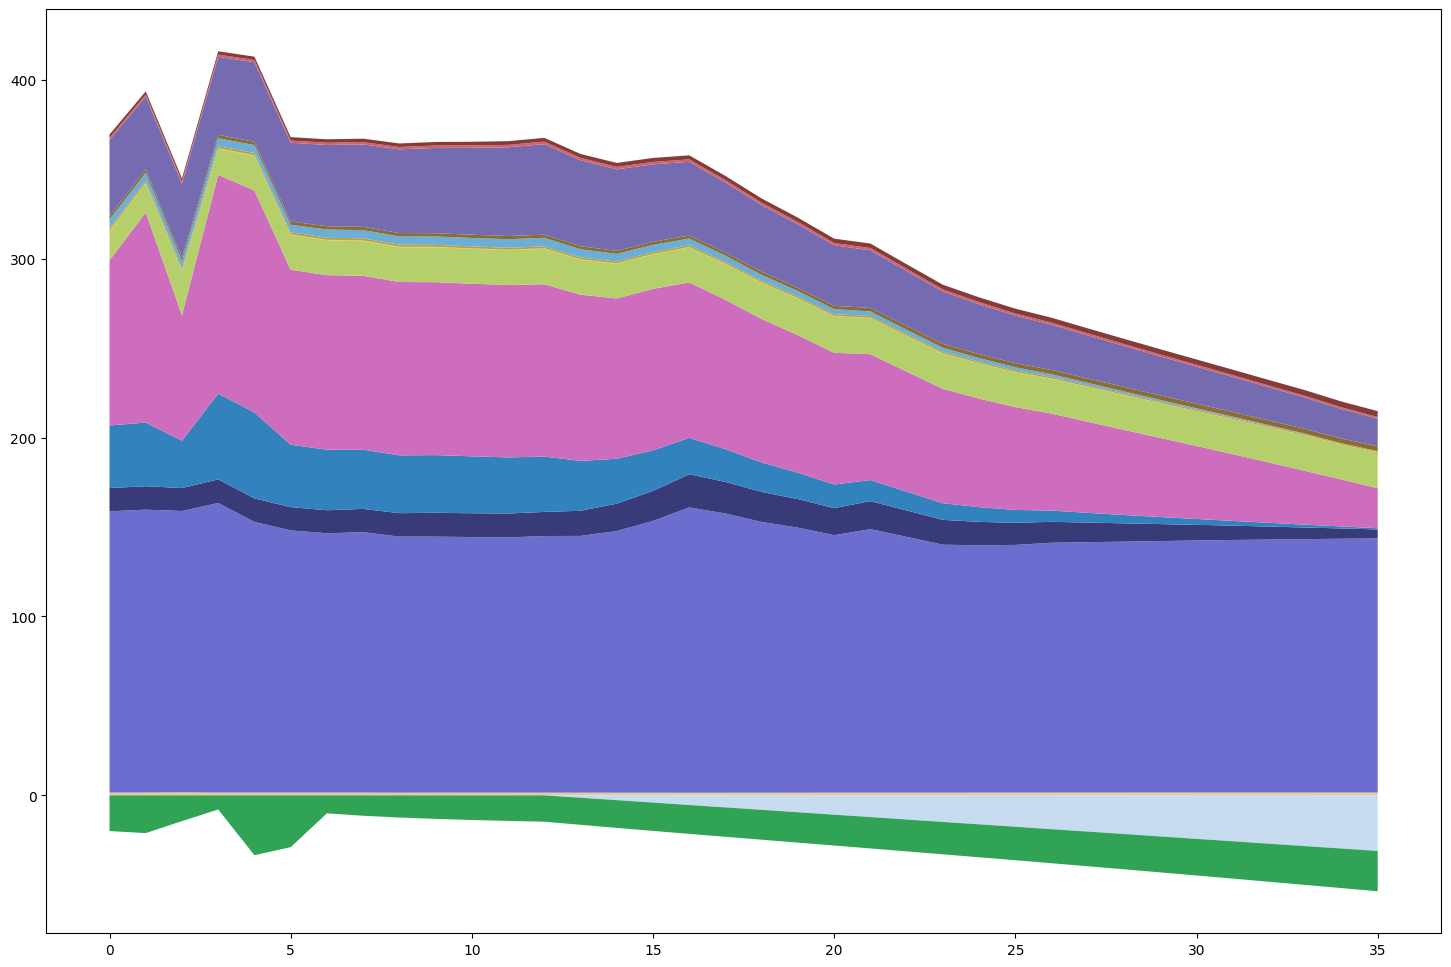

In [674]:
svp.plot_emissions_stack(
    df_out_6006,
    matt,
)

<Axes: >

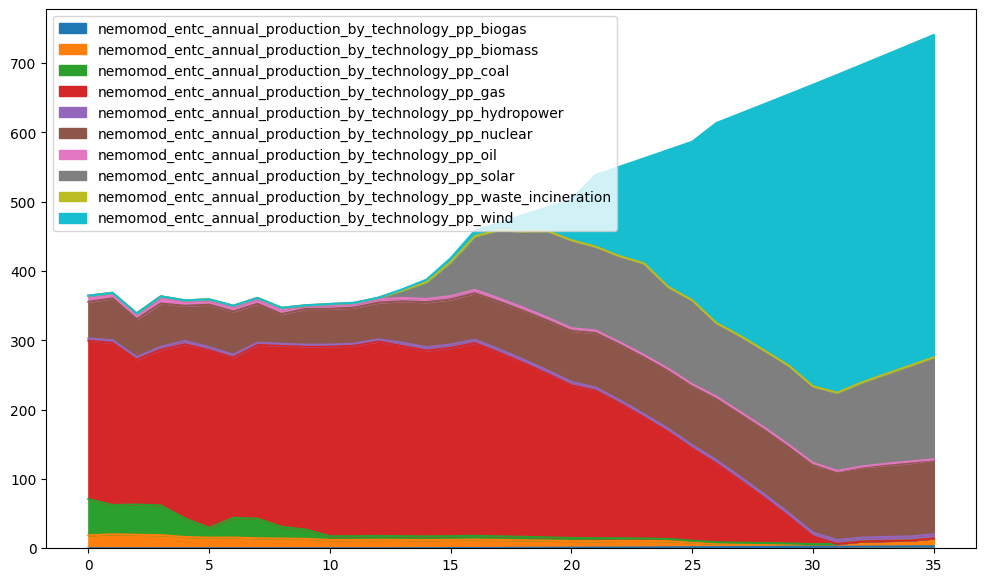

In [672]:
df = df_out_6004

modvar_pbt = matt.get_variable("NemoMod Production by Technology")
flds = [x for x in df.columns if "nemomod_entc_annual_production_by_technology_" in x and df[x].max() > 0]
df_plot = df[flds].copy()
arr_plot = sf.vec_bounds(df_plot[flds], (0, np.inf))
df_plot[flds] = arr_plot


fig, ax = plt.subplots(figsize = (12, 7))
df_plot.plot.area(ax = ax, legend = True, )



# build transformations

In [544]:
import sisepuede.transformers.strategies as sts
import sisepuede.transformers.transformations as trnf
importlib.reload(sts)
importlib.reload(trnf.trs.tbe)
importlib.reload(trnf.trs)
importlib.reload(trnf)


if not path_transformations.exists():
    print("BUILDING DEFAULT TRANSFORMATIONS")
    trf.instantiate_default_strategy_directory(
        transformers,
        path_transformations,
    )

# then, you can load this back in after modifying (play around with it)
transformations = trnf.Transformations(
    path_transformations,
    df_input = df_input
)
tab = transformations.attribute_transformation.table
transformers = transformations.transformers

# build strategies


#  build the strategies -- will export to path
t0 = time.time()
strategies = sts.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

# build whirlpool with existing data
# tss = strategies.build_whirlpool_strategies(6004, ids = list(range(7101, 7160)))


##  GET XL SPECIFICATIONS AND SAMPLE GROUPS

# base off of the LA strat
strat = strategies.get_strategy(6004)

transformations_include = strat.get_transformation_list(
    strat.transformation_specification,
    transformations,
)

_FIELD_VARIABLE = "variable"
_FIELD_VARIABLE_TRAJECTORY_GROUP = "variable_trajectory_group"

df_transformation_code_to_varchange = transformations.get_transformations_variable_fields(
    transformations_include = transformations_include,
    include_all_variable_fields_by_modvar = False, 
    include_sample_group = True,
    field_sample_group = _FIELD_VARIABLE_TRAJECTORY_GROUP,
    field_variable = _FIELD_VARIABLE,
)



Strategies defined at /Users/usuario/git/sisepuede_region_nbs/louisiana/transformations initialized in 3.74 seconds


In [545]:
2+2

4

In [233]:
strat = strategies.get_strategy(0)
df_0 = strat()

strat = strategies.get_strategy(6004)
df_6004 = strat()

strat = strategies.get_strategy(6006)
df_6006 = strat()


In [199]:
df_out_6004 = models.project(
    df_6004,
    include_electricity_in_energy = True,
    time_periods_base = np.arange(12),
)


2025-02-Oct 23:34:27.893 Opened SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-02-Oct 23:34:27.929 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-02-Oct 23:34:28.709 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-02-Oct 23:34:28.820 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-02-Oct 23:34:42.908 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-02-Oct 23:34:42.945 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-02-Oct 23:36:33.154 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026

In [234]:
df_input2 = df_input.copy()
vec_ramp = sf.ramp_vector(df_input.shape[0], r_0 = 12)*1.5
#field = "demscalar_ippu_other_product_manufacturing"

#df_input2[field] = vec_ramp
df_out2 = models.project(
    df_input,
    include_electricity_in_energy = False,
)

In [ ]:
df_out2[[x for x in df_out2.columns if ("energy_demand" in x)]]

In [235]:
[x for x in df_out2.columns if ("energy_cons" in x)]
df_out2["energy_consumption_electricity_inen_other_product_manufacturing"]





0      0.029715
1      0.024682
2      0.024181
3      0.023704
4      0.024335
5      0.024543
6      0.023686
7      0.022989
8      0.022564
9      0.022068
10     0.021533
11     0.020944
12     0.020355
13     0.019785
14     0.019233
15    71.764772
16    71.479084
17    71.194571
18    70.911234
19    70.629071
20    70.348081
21    70.068265
22    69.789620
23    69.512145
24    69.235837
25    68.960693
26    68.686708
27    68.413877
28    68.142197
29    67.871663
30    67.602265
31    67.333998
32    67.066855
33    66.800832
34    66.535920
35    66.272112
Name: energy_consumption_electricity_inen_other_product_manufacturing, dtype: float64

# Build uncertainty ranges that we want for an experiment
- Call from `build_uncertainty_groups`

In [466]:
import build_uncertainty_groups as bg
importlib.reload(bg)

_FIELD_TRAJGROUP = strategies.input_template.field_req_variable_trajectory_group
_FIELD_VARIABLE = strategies.input_template.field_req_variable
_DF_UNCERTAINTY = bg.main(strategies)






[]


In [ ]:
"""
path_write = "/Users/usuario/Documents/Projects/Louisiana/experiments/attributes_and_info/sisepuede_run_2025-10-07T13;30;14.193421/uncertainty_groups_and_ranges.csv"
_DF_UNCERTAINTY.to_csv(
    path_write,
    index = None, 
    encoding = "UTF-8",
)
"""


##  Build the `trajgroups` input

In [467]:
df_trajgroups = (
    df_transformation_code_to_varchange
    .get(
        [
            "variable_field",
            _FIELD_TRAJGROUP
        ]
    )
    .copy()
    .drop_duplicates()
    .reset_index(drop = True, )
    .rename(columns = {"variable_field": _FIELD_VARIABLE, })
)

df_uncertainty_component = _DF_UNCERTAINTY[[_FIELD_VARIABLE, _FIELD_TRAJGROUP]]
df_uncertainty_component[_FIELD_TRAJGROUP] += df_trajgroups[_FIELD_TRAJGROUP].max()

# check that there are no overlappin4g fields
shared_vfs = set(df_trajgroups[_FIELD_VARIABLE]) & set(df_uncertainty_component[_FIELD_VARIABLE])
if len(shared_vfs) > 0:
    raise RuntimeError("Cannot have overlapping fields in this merge")

df_trajgroups = sf._concat_df(
    [
        df_trajgroups,
        df_uncertainty_component,
    ]
)



In [477]:
## tp_max = max(time_periods.all_time_periods)
field_max, field_min = bg.get_max_min_field(strategies, tp_max, )


strategies.build_strategies_to_templates(
    df_trajgroup = df_trajgroups,
    df_variable_info = _DF_UNCERTAINTY[[_FIELD_VARIABLE, field_min, field_max]],
    dict_variable_missing_val = {
        field_min: 1.0,
        field_max: 1.0,
    },
    include_simplex_group_as_trajgroup = False,
    strategies = [0] + [6004]#list(range(6004, 6017)),#strategies.all_strategies,#list(range(7101, 7160)),#[0, 6003, 6004, 6005] #+ list(range(7001, 7062)), # list(range(7101, 7160))
)

0

In [473]:
_REGION_NAME = "louisiana"
fut = ssp.experimental_manager.dict_future_trajectories.get(_REGION_NAME)
lhs_design = ssp.experimental_manager.dict_lhs_design.get(_REGION_NAME)

df_x = pd.DataFrame(
    lhs_design.arr_lhs_x,
    columns = lhs_design.fields_factors_x,
)

##  get a dictionary that maps the uncertainty group to the associated sample group in SISEPUEDE
dict_grp_to_sg_ssp = pd.merge(
    _DF_UNCERTAINTY,
    df_uncertainty_component
    .rename(
        columns = {
            _FIELD_TRAJGROUP: "uc"
        }
    )
)

dict_grp_to_sg_ssp = sf.build_dict(
    dict_grp_to_sg_ssp[[_FIELD_TRAJGROUP, "uc"]]
)





# Build some plots for the report (Chapter 4)


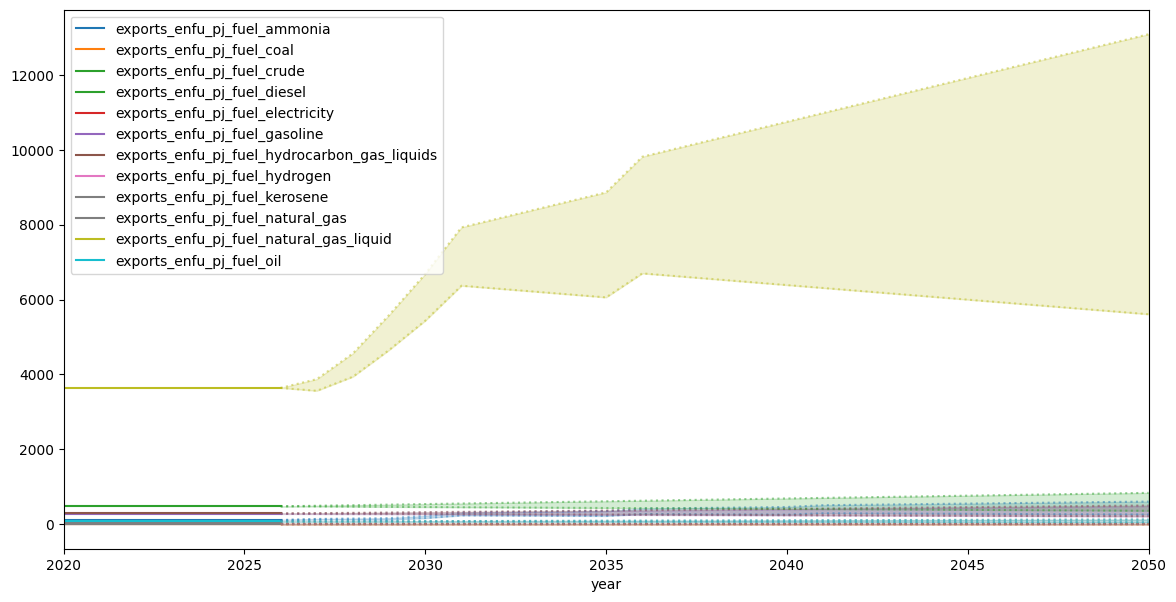

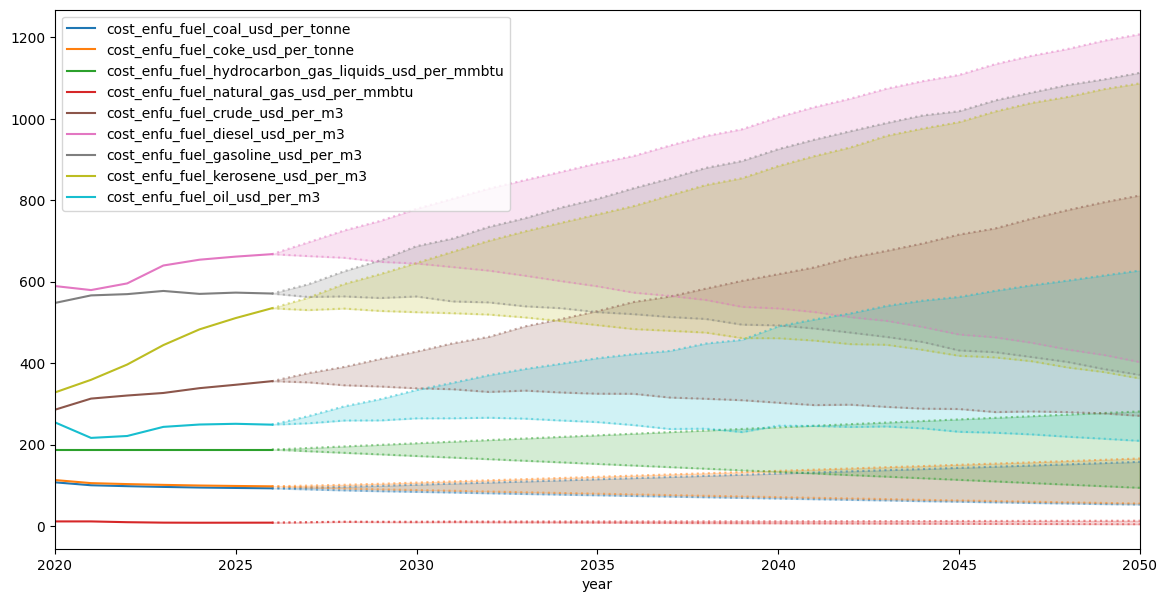

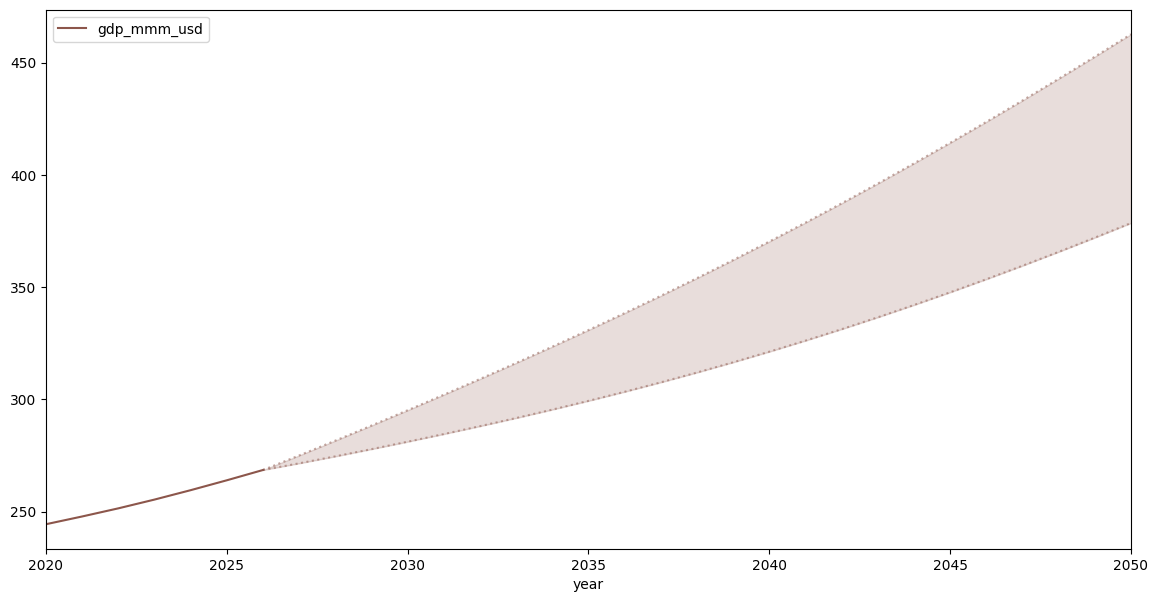

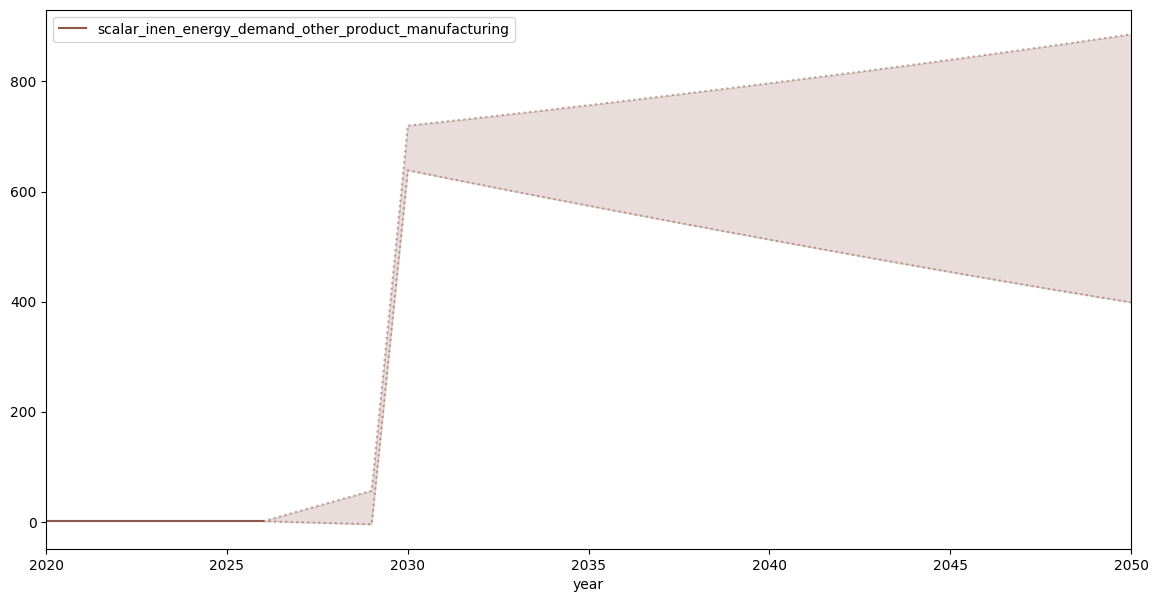

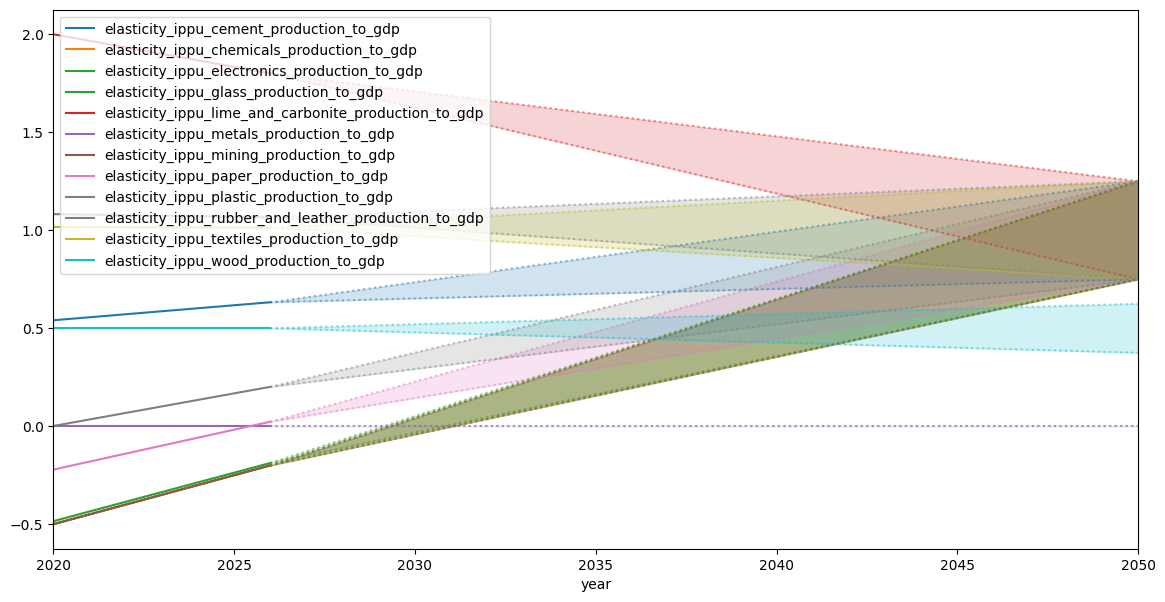

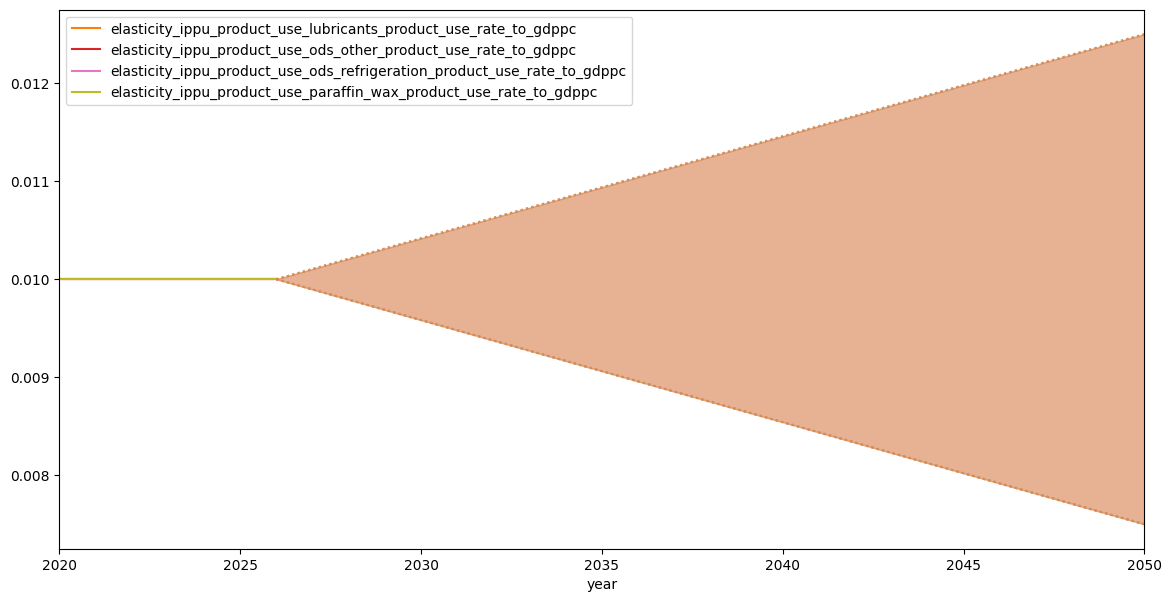

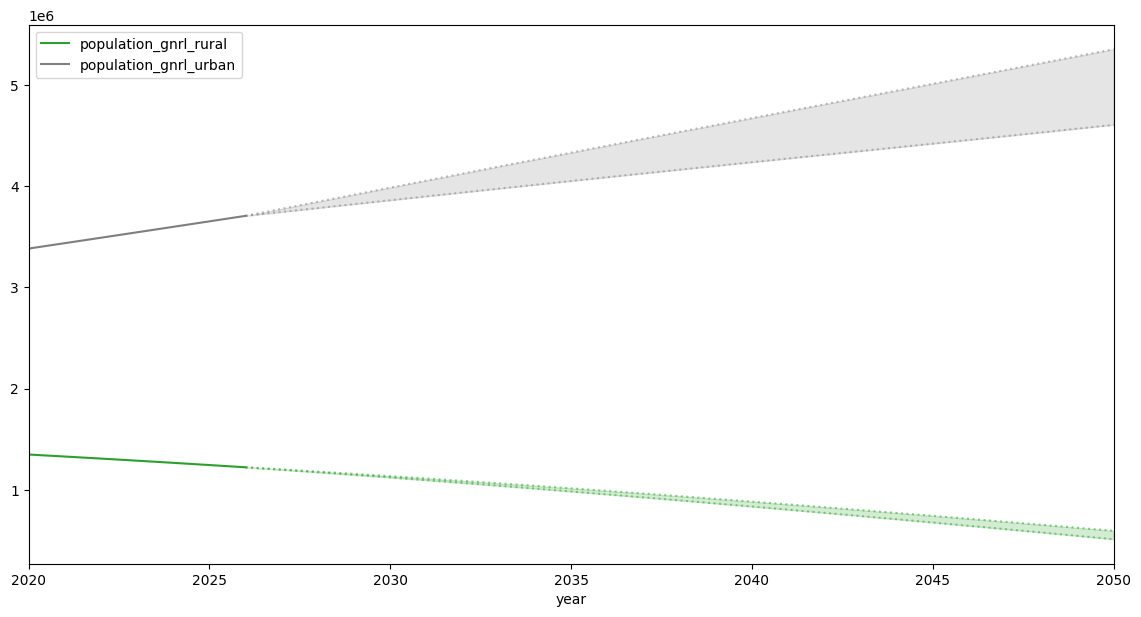

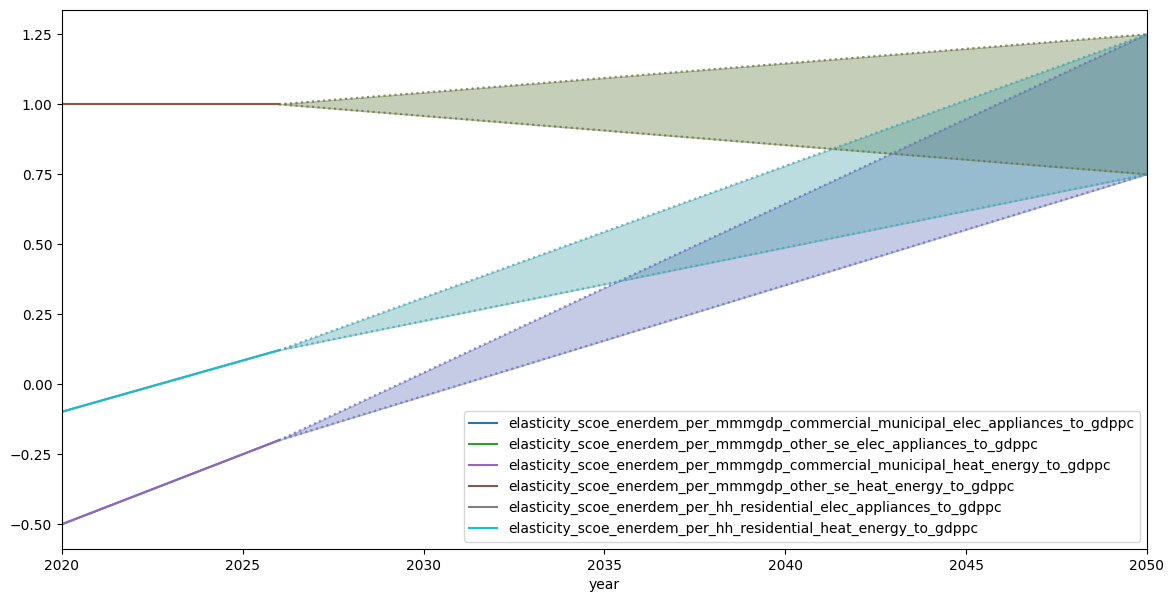

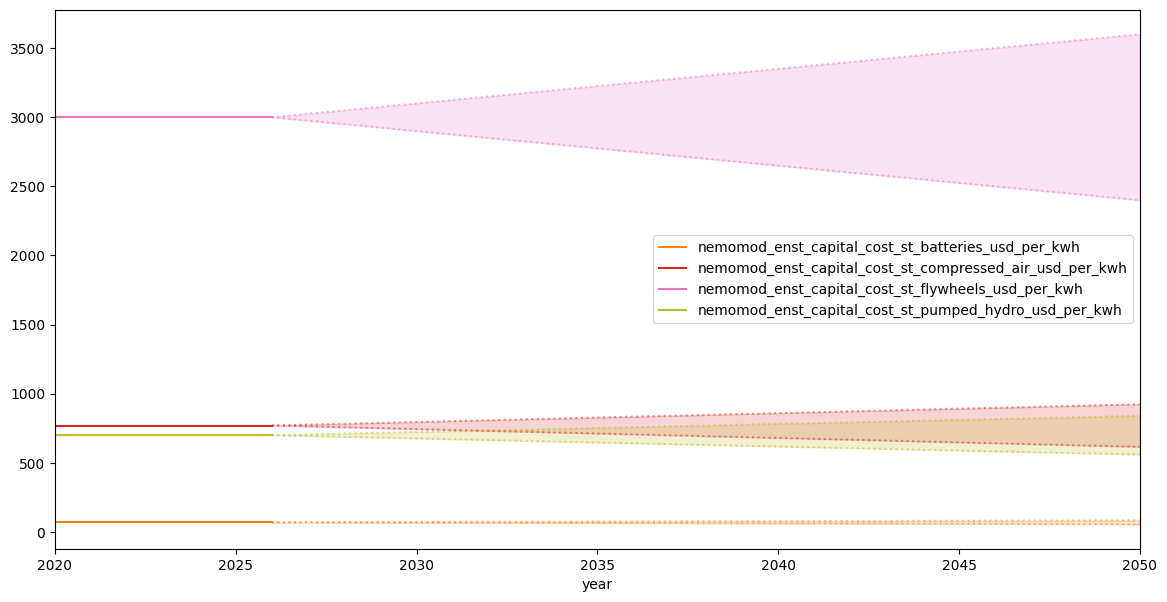

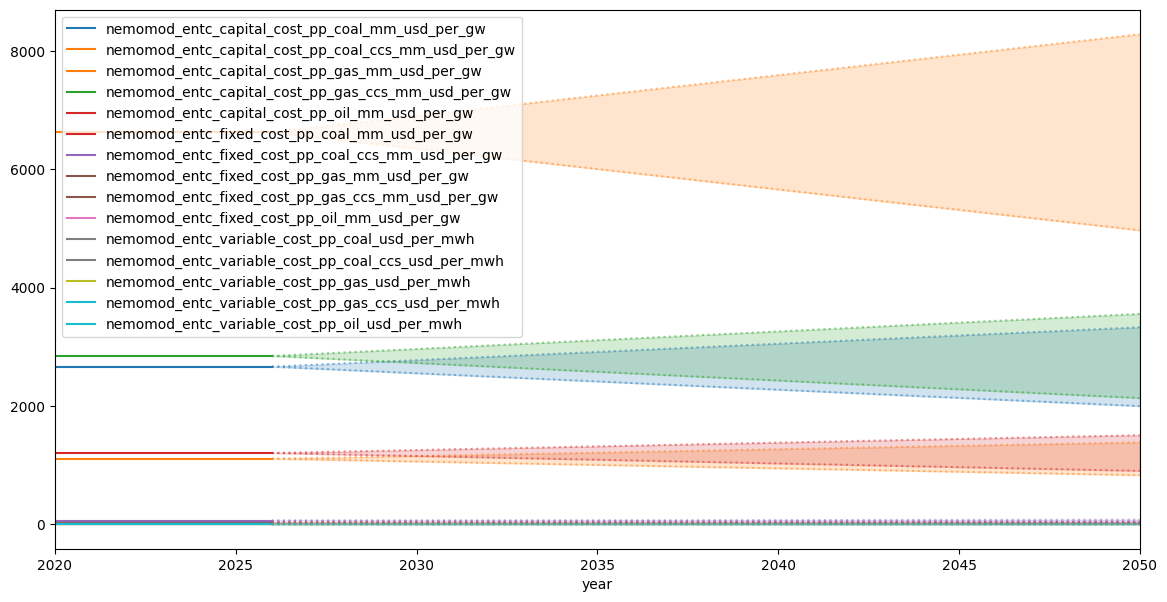

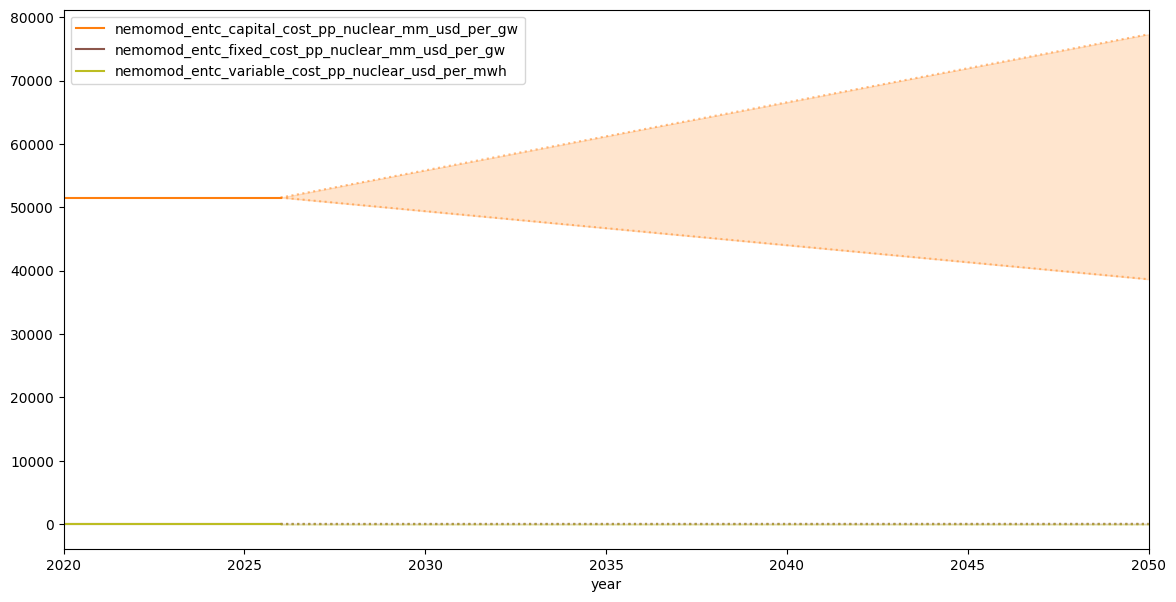

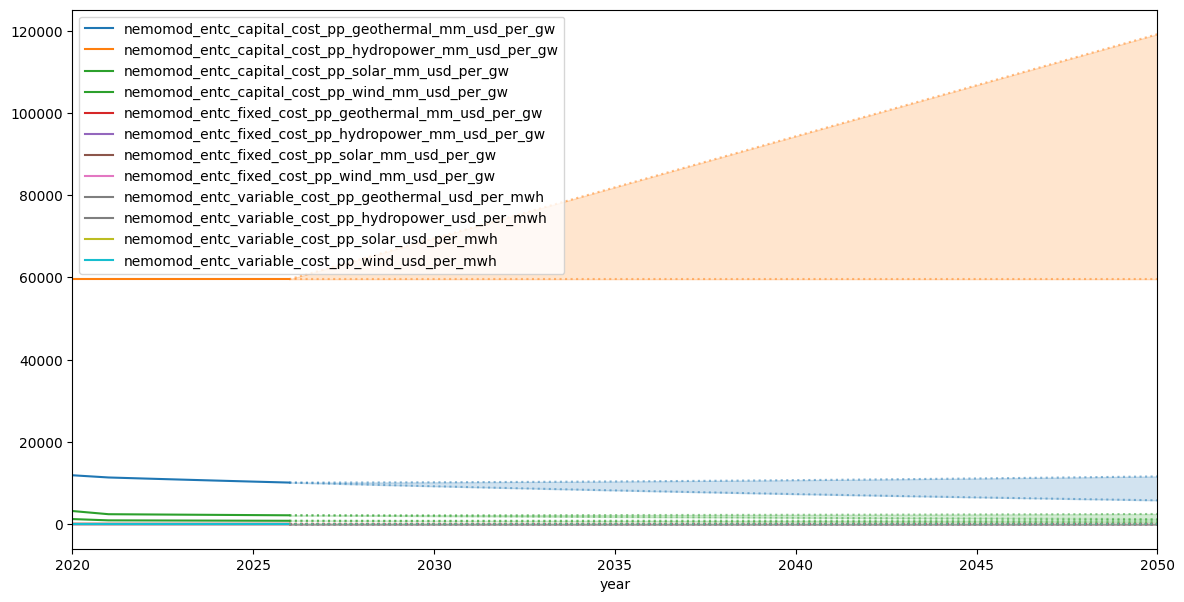

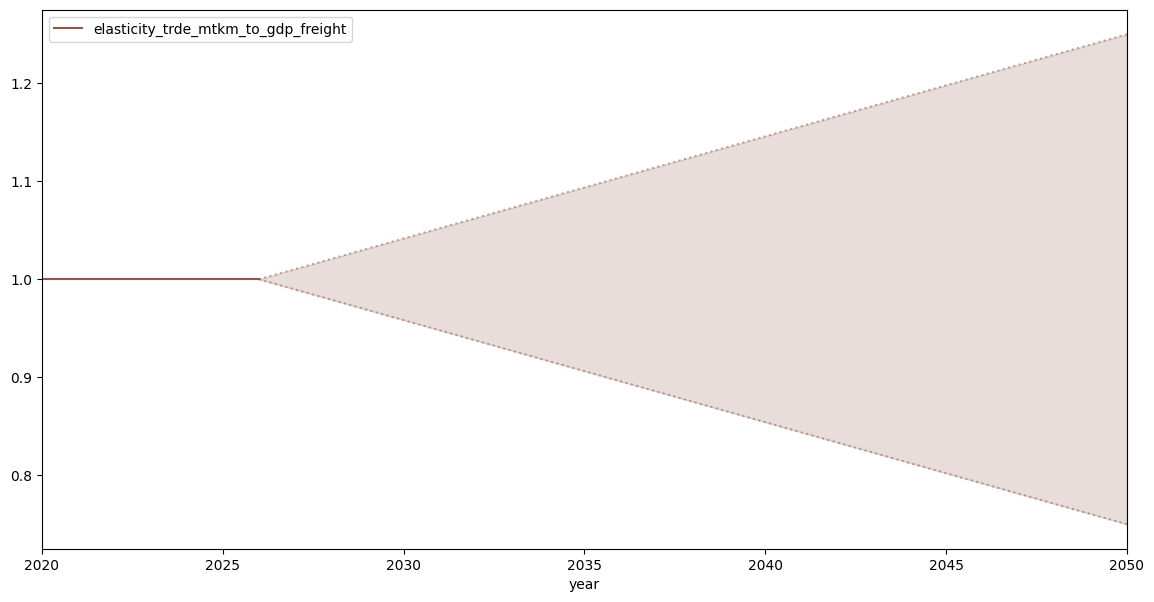

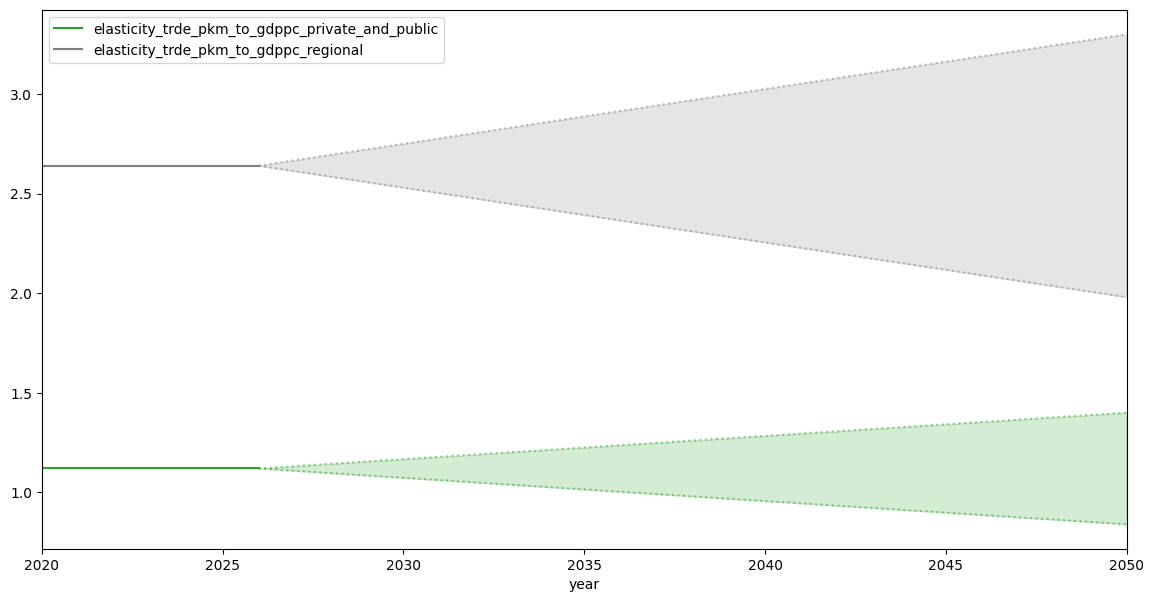

In [474]:
import matplotlib


def build_fan_plot(
    dict_dfs_cur: Dict[str, pd.DataFrame],
) -> 'plt.Plot':
    """Build the plot to show in the uncertainty descriptions for LEAP
    """
    cmap = matplotlib.cm.get_cmap('tab10')
    
    fig, ax = plt.subplots(figsize = (14, 7))

    year_base = 2020
    year_split = 2026


    ##  SUBSET DFS
    
    df_dummy = dict_dfs_cur.get("max").copy()
    df_dummy = (
        df_dummy[
            (df_dummy[time_periods.field_year] <= year_split)
            & (df_dummy[time_periods.field_year] >= year_base)
        ]
        .reset_index(drop = True)
    )

    # max 
    df_max = dict_dfs_cur.get("max").copy()
    df_max = (
        df_max[
            (df_max[time_periods.field_year] >= year_split)
        ]
        .reset_index(drop = True)
    )

    # min
    df_min = dict_dfs_cur.get("min").copy()
    df_min = (
        df_min[
            (df_min[time_periods.field_year] >= year_split)
        ]
        .reset_index(drop = True)
    )

    
    # fields to plot
    fields_plot = [x for x in df_dummy.columns if x != time_periods.field_year]
    fields_ord = [time_periods.field_year] + fields_plot
    
    
    dict_color = dict(
        (k, cmap((2*i + 1)/(2*len(fields_plot))))
        for i, k in enumerate(fields_plot)
    )
    
    # plot dummy to build legend
    (
        #dict_dfs_cur
        #.get("max")
        df_dummy
        .get(fields_ord)
        .plot(
            ax = ax,
            color = dict_color,
            #cmap = cmap,
            x = time_periods.field_year,
        )
    )
    
    
    # plot dummy to build legend
    (
        df_max
        .get(fields_ord)
        .plot(
            alpha = 0.5,
            ax = ax,
            color = dict_color,
            #cmap = cmap,
            legend = False,
            linestyle = ":",
            x = time_periods.field_year,
        )
    )
    
    (
        df_min
        .get(fields_ord)
        .plot(
            alpha = 0.5,
            ax = ax,
            color = dict_color,
            #cmap = cmap,
            legend = False,
            linestyle = ":",
            x = time_periods.field_year,
        )
    )
    
    i = 0
    for field in fields_ord:
        i += 1
        if field == time_periods.field_year: continue
    
        x = df_min[time_periods.field_year]
        y0 = df_min[field]
        y1 = df_max[field]
        
        ax.fill_between(x, y0, y1, alpha = 0.2, color = dict_color.get(field), )
    

    ax.set_xlim(year_base, 2050)
    
    return (fig, ax)






dfg = _DF_UNCERTAINTY.groupby(_FIELD_TRAJGROUP)
dict_lhs = {
    "min": 0.0,
    "max": 1.0,
}

# output data frames
dict_dfs = {}
dict_plots = {}

j = 0

for i, df in dfg:
    #if j > 2: continue
        
    fields_plot = list(df[_FIELD_VARIABLE])
    row_base = df_x.iloc[0]
    field = dict_grp_to_sg_ssp.get(i)


    dict_dfs_cur = {}
    
    # build max/min
    for k, v in dict_lhs.items():
        row_cur = row_base.copy()
        row_cur[field] = v

        # generate the future
        df_fut = fut.generate_future_from_lhs_vector(
            row_cur,
        )

        # add year for plotting
        df_fut = (
            time_periods
            .tps_to_years(
                df_fut[
                    df_fut[ssp.key_strategy].isin([ssp.baseline_strategy])
                ],
            )
            .get([time_periods.field_year] + fields_plot)
        )
        
        dict_dfs_cur.update({k: df_fut, })


    plt_tuple = build_fan_plot(dict_dfs_cur, )
    dict_plots.update({i: plt_tuple, })
    
    j += 1
    

In [475]:
path_figures = path_cur.joinpath("figures")
if not path_figures.is_dir():
    os.makedirs(path_figures, exist_ok = True, )

for k, v in dict_plots.items():
    fn_out = f"uncertainty_ranges_sg_{k}.png"
    path_out = path_figures.joinpath(fn_out)
    v[0].savefig(path_out, bbox_inches = "tight", dpi = 300, )

In [485]:
matt.get_gwp("ch4")

27.9

In [482]:
df_out[
    df_out[ssp.key_primary].isin([368368])
][[x for x in df_out.columns if "emission_co2e_n2o_ippu" in x]]


,emission_co2e_n2o_ippu_production_chemicals,emission_co2e_n2o_ippu_production_other_product_manufacturing,emission_co2e_n2o_ippu_production_paper,emission_co2e_n2o_ippu_production_plastic
0,59.110530,0.0,0.0,0.0
1,79.815470,0.0,0.0,0.0
2,49.110934,0.0,0.0,0.0
3,85.740313,0.0,0.0,0.0
4,84.399426,0.0,0.0,0.0
5,61.409523,0.0,0.0,0.0
6,60.976120,0.0,0.0,0.0
7,60.575265,0.0,0.0,0.0
8,60.198634,0.0,0.0,0.0
9,59.853284,0.0,0.0,0.0


In [486]:
path_out = pathlib.Path("/Users/usuario/Documents/Projects/Louisiana/experiments/attributes_and_info/sisepuede_run_2025-10-07T13;30;14.193421")

if not path_out.is_dir():
    path_out.mkdir(exist_ok = True, )
    
df_transformation_code_to_varchange.to_csv(
    path_out.joinpath("VARIABLE_TRAJECTORY_GROUPS_L.csv"),
    index = None,
    encoding = "UTF-8",
)

df_uncertainty_component.to_csv(
    path_out.joinpath("VARIABLE_TRAJECTORY_GROUPS_X.csv"),
    index = None,
    encoding = "UTF-8",
)

# START--build low implementation strategy configs

In [170]:
strat = strategies.get_strategy(6004)
transformations_list_all_la = strat.get_transformation_list(
    strat.transformation_specification,
    strategies.transformations,
)



In [1097]:
import sisepuede.models.energy_consumption as ec
importlib.reload(ec)
mec = ec.EnergyConsumption(matt, )

df_proj = models(
    df_6006,
    models_run = ["af", "ce", "ip"]
)

df_pass = pd.merge(
    df_6006,
    df_proj
)

df_mec = mec(df_pass, )

In [507]:
def copy_to_medium_intensity(
    transformations: 'Transformations',
    all_codes: List[str],
    export: bool = False,
    key_magnitude: str = "magnitude",
    key_tp0: str = "tp_0_ramp",
    key_vir: str = "vec_implementation_ramp",
    verbose: bool = True,
) -> None:
    """Copy NDC transformations to NDC 2.0 with time starting in 2020
    """
    paths_transformations_cur = transformations.dict_paths.get(
        transformations.key_path_transformations, 
    )

    all_codes_out = []

    # iterate over each path
    for path in paths_transformations_cur:

        # get and check the code associated with this YAML
        transformation = trf.Transformation(
            path,
            transformations.transformers,
        )
        
        # skip any non-ndc transformations
        if transformation.code not in all_codes:
            continue


        ##  SET OUTPUT PATH AND EXPORT
        
        path_out = path.stem
        append = "_MIDINTENS"
        path_out = f"{path_out}{append}{path.suffix}"
        path_out = path.parents[0].joinpath(path_out)
        

        ##  UPDATE YAML - START WITH MAGNITUDE
            
        # get the parameters and update the start time
        dict_yaml = sf.read_yaml(path, munchify_dict = False, )
        dict_params = dict_yaml.get(transformation.key_parameters, )

        # get the magnitude from parameters and update as necessary
        mag = dict_params.get(key_magnitude)
        if mag is not None:
            dict_params.update({key_magnitude: mag/2, })
            if verbose: print(f"{transformation.code} magnitude updated successfully.")

        elif verbose: 
            print(f"\tNO MAGNITUDE: check {transformation.code} at '{path_out}'")
 
        dict_yaml.update({transformation.key_parameters: dict_params, })


        ##  UPDATE IDENTIFICATION INFO
        
        dict_ids = dict_yaml.get(transformation.key_identifiers, )

        # update the code
        code = dict_ids.get(transformation.key_transformation_code, )
        code = f"{code}{append}"
        dict_ids.update({transformation.key_transformation_code: code, })

        # update the name
        name = dict_ids.get(transformation.key_transformation_name, )
        name = f"{name} at medium intensity for jobs run"
        dict_ids.update({transformation.key_transformation_name: name, })

        dict_yaml.update({transformation.key_identifiers: dict_ids, })

        
        
        # write output?
        if export: sf._write_yaml(dict_yaml, path_out, )

        # finally, add to all codes to build new strategy
        all_codes_out.append(code)

    
    all_codes_out.sort()

    return all_codes_out





# already exported, no need to do it again at the moment
all_codes_mid = copy_to_medium_intensity(
    transformations, 
    [x.code for x in transformations_list_all_la],
    export = False, 
    verbose = False,
);

all_codes_mid_build = [
    x for x in all_codes_mid 
    if x not in ["TX:PFLO:INC_HEALTHIER_DIETS_MIDINTENS", "TX:ENTC:LEAST_COST_SOLUTION_MIDINTENS"]
]



##  Add in strategies for sub-subsector groupings in energy from Alison


In [655]:
df_transformation_groupings = pd.read_excel(
    path_transformations.joinpath("TWI_20250814_Table_Sector Transformation Groups.xlsx"),
    sheet_name = None,
)


df_definitions = (
    df_transformation_groupings.get("LEAP Run List")
    .drop(columns = "Unnamed: 1")
    .iloc[1:]
)

_FIELD_RUNS = "Runs:"
fields_strats = [x for x in df_definitions.columns if x not in [_FIELD_RUNS]]

# convert the strategy columns to a name and code
def column_to_code_name(
    col_name: str,
) -> Tuple[str, str]:
    """Using a column name, convert to code, name tuple
    """

    col_name = (
        col_name
        .replace("T&B", "Transport and Buildings")
        .replace("&", "and")
    )
    
    name = f"TWI energy Subsector {col_name}"
    code = (
        col_name
        .upper()
        .replace(" ", "_")
    )
    code = f"PFLO:TWI_{code}"

    out = (code, name, )

    return out


# get info in a dict
dict_strats_twi = {}

def clean_transformation(
    tr_name: str,
) -> str:
    """Clean the transformation string
    """
    out = tr_name.split()[1]
    return out





strategy_id_new = max(strategies.all_strategies) + 1
df_out = []
delim = "|"
for fld in fields_strats:
    code, name = column_to_code_name(fld, )

    df_filt = (
        df_definitions[[_FIELD_RUNS, fld]]
        .dropna()
    )

    transformations_out = delim.join(
        sorted(
            list(
                df_filt[_FIELD_RUNS]
                .apply(clean_transformation, )
            )
        )
    )

    row_new = [
        strategy_id_new,
        code,
        name,
        f"Defined by TWI 20250814 - {name}",
        transformations_out,
        0
    ]

    df_out.append(row_new)
    strategy_id_new += 1



cols_new = [
    strategies.key_strategy,
    strategies.field_strategy_code,
    strategies.field_strategy_name,
    strategies.field_description,
    strategies.field_transformation_specification,
    strategies.field_baseline_strategy
]

df_out = pd.DataFrame(
    df_out,
    columns = cols_new,
)


In [656]:

# get the current table
tab = strategies.attribute_table.table
tab = tab[
    ~tab[strategies.key_strategy].isin([_STRAT_ID_NEW])
]

tab = (
    pd.concat(
        [
            tab,
            df_out
        ],
        axis = 0,
    )
    .sort_values(by = [strategies.key_strategy])
    .reset_index(drop = True, )
)

In [658]:
# export?
if True:
    tab.to_csv(
        strategies.path_strategy_definition,
        encoding = "UTF-8",
        index = None,
    )





In [732]:
_STRAT_ID_NEW = 6005

# get the current table
tab = strategies.attribute_table.table
tab = tab[
    ~tab[strategies.key_strategy].isin([_STRAT_ID_NEW])
]

# add a new row
row_new = {
    strategies.key_strategy: _STRAT_ID_NEW,
    strategies.field_strategy_code: "PFLO:ALL_LA_ACTIONS_MEDIUM_INTENSITY",
    strategies.field_strategy_name: "All Louisiana Actions at medium (approx 50%) intensity",
    strategies.field_description: "Includes all actions evaluate in LEAP, but with lower intensity of implementation.", 
    strategies.field_transformation_specification: "|".join(all_codes_mid_build),
    strategies.field_baseline_strategy: 0
}

tab = (
    pd.concat(
        [
            tab,
            pd.DataFrame(pd.Series(row_new)).transpose(),
        ],
        axis = 0,
    )
    .sort_values(by = [strategies.key_strategy])
    .reset_index(drop = True, )
)

# export?
if True:
    tab.to_csv(
        strategies.path_strategy_definition,
        encoding = "UTF-8",
        index = None,
    )

# Run the model


In [546]:

ssp = si.SISEPUEDE(
    "calibrated",
    # attribute_time_period = attr_time_period,
    db_type = "csv",                          # must run as a CSV for now
    initialize_as_dummy = False,              # no connection to Julia is initialized if set to True
    logger = log_job,
    random_seed = 446182,
    regions = ["louisiana"],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = False,
)

log_job = ssp.logger




2025-10-17 09:51:50,355 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-10-17 09:51:50,356 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-10-17 09:51:50,357 - INFO - 	Setting export engine to 'csv'.
2025-10-17 09:51:50,357 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-10-17 09:51:50,357 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-10-17 09:51:50,357 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-10-17 09:51:50,358 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-10-17 09:51:50,358 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-10-17 09:51:50,358 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-10-17 09:51:50,358 - WARNING - No index fi

# Check the design id--here's where we'll leverage it
- `design_id` controls what variables vary where; we'll vary the effects only
- as of the latest run (20250114), `design_id 3` varies lever effects (LEs) only between 10% and 100% of implementation

In [284]:
"""att = matt.get_dimensional_attribute_table(matt.dim_design_id)
tab = att.table
dict_append = {
    ssp.key_design: [4],
    "vary_l": [1],
    "vary_x": [1],
    "linear_transform_l_m": [1.0],
    "linear_transform_l_b": [0.0],
    "linear_transform_l_inf": [0.0],
    "linear_transform_l_sup": [1.0],
    "design_name": ["Vary Xs and LEs with full range of LE"],
    "include": [1]
}

tab_new = pd.concat([tab, pd.DataFrame(dict_append)])
tab_new.to_csv(
    att.fp_table,
    encoding = "UTF-8",
    index = None,
)
"""
matt.get_dimensional_attribute_table(matt.dim_design_id)

,design_id,vary_l,vary_x,linear_transform_l_m,linear_transform_l_b,linear_transform_l_inf,linear_transform_l_sup,design_name,include
0,0,0,1,1.00,0.00,1.00,1,Vary Xs (design 0),1
1,1,1,1,0.75,0.25,0.25,1,Vary Xs and Les; Cap LE at 1 (design 1),1
2,2,1,1,1.25,0.00,0.25,1,"Vary Xs and LEs; Cap LE at 1.1 (design 2, 20% ...",1
3,3,1,0,0.90,0.10,0.10,1,Vary LEs; (design 3),1


In [468]:
"""#lhs_design.fields_vary_l
#dir(lhs_design)
lhs_design.arr_lhs_l.shape
df_out = pd.DataFrame(
    lhs_design.arr_lhs_l,
)
df_out.columns = lhs_design.fields_factors_l
df_out["future_id"] = range(1, df_out.shape[0] + 1)

df_out.to_csv("/Users/usuario/Desktop/lhs_sample_group_experiments.csv", index = None, encoding = "UTF-8")
""";

In [ ]:
"""
#vol_prod_kft3 = 4317315*(10**9)
vol_prod_kft3 = 500_000*(10**3)  # 500000 million cubic ft, 500,000,000 thousand cubic ft
vol_prod_litres = vol_prod_kft3*matt.get_unit("volume").convert("kft3", "litre")

modvar_ved = matt.get_variable("Volumetric Energy Density")
field = modvar_ved.build_fields(
    category_restrictions = "fuel_natural_gas"
)
mj_per_litre = df_0[field].iloc[0]


energy_prod_mj = vol_prod_litres*mj_per_litre
energy_prod_pj = energy_prod_mj/(10**9)
energy_prod_pj
"""

##  Run the model here
- will specify `strategy_id` associated with All Actions and `design_id = 3`
- do not specify `future_id` because we are running across all available futures

In [550]:
dict_scens = {
    # we exclude future because we will run across all futures
    ssp.key_design: [4],
    ssp.key_future: [0],
    ssp.key_strategy: [0] + [6004],#list(range(6004, 6026)),
    # ssp.key_primary: [405329, 404942]
}


ssp.project_scenarios(
    dict_scens,
    check_results = False,
    force_overwrite_existing_primary_keys = True,
    save_inputs = True,
)


2025-10-17 09:56:27,286 - INFO - 
***	STARTING REGION louisiana	***

2025-10-17 09:56:28,366 - INFO - Trying run primary_id = 368368 in region louisiana
2025-10-17 09:56:28,366 - INFO - Running AFOLU model
2025-10-17 09:56:28,628 - INFO - AFOLU model run successfully completed
2025-10-17 09:56:28,629 - INFO - Running CircularEconomy model
2025-10-17 09:56:28,655 - INFO - CircularEconomy model run successfully completed
2025-10-17 09:56:28,656 - INFO - Running IPPU model
2025-10-17 09:56:28,695 - INFO - IPPU model run successfully completed
2025-10-17 09:56:28,695 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-17 09:56:28,706 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-10-17 09:56:28,754 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-10-17 09:56:28,755 - INFO - Running Energy model (Electricity and Fuel Productio

2025-17-Oct 09:56:28.779 Opened SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-17-Oct 09:56:28.794 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-17-Oct 09:56:29.416 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-17-Oct 09:56:29.488 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].


2025-10-17 09:58:57,520 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-10-17 09:58:57,528 - INFO - EnergyProduction model run successfully completed
2025-10-17 09:58:57,529 - INFO - Running Energy (Fugitive Emissions)
2025-10-17 09:58:57,552 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-10-17 09:58:57,552 - INFO - Appending Socioeconomic outputs
2025-10-17 09:58:57,557 - INFO - Socioeconomic outputs successfully appended.
2025-10-17 09:58:57,559 - INFO - Model run for primary_id = 368368 successfully completed in 149.19 seconds (n_tries = 1).
2025-10-17 09:58:57,573 - INFO - Trying run primary_id = 438438 in region louisiana
2025-10-17 09:58:57,574 - INFO - Running AFOLU model


2025-17-Oct 09:56:42.799 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-17-Oct 09:56:42.831 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-17-Oct 09:58:57.418 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-17 09:58:57,845 - INFO - AFOLU model run successfully completed
2025-10-17 09:58:57,845 - INFO - Running CircularEconomy model
2025-10-17 09:58:57,868 - INFO - CircularEconomy model run successfully completed
2025-10-17 09:58:57,869 - INFO - Running IPPU model
2025-10-17 09:58:57,909 - INFO - IPPU model run successfully completed
2025-10-17 09:58:57,909 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-17 09:58:57,920 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-10-17 09:58:57,968 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-10-17 09:58:57,969 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-17-Oct 09:58:58.605 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-17-Oct 09:58:58.661 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-17-Oct 09:59:13.904 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011].
2025-17-Oct 09:59:13.937 Started optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].


2025-10-17 10:00:27,595 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-10-17 10:00:27,608 - INFO - EnergyProduction model run successfully completed
2025-10-17 10:00:27,608 - INFO - Running Energy (Fugitive Emissions)
2025-10-17 10:00:27,630 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-10-17 10:00:27,631 - INFO - Appending Socioeconomic outputs
2025-10-17 10:00:27,636 - INFO - Socioeconomic outputs successfully appended.
2025-10-17 10:00:27,637 - INFO - Model run for primary_id = 438438 successfully completed in 90.06 seconds (n_tries = 1).
2025-10-17 10:00:27,642 - INFO - 
***	 REGION louisiana COMPLETE	***

2025-10-17 10:00:27,704 - INFO - Table MODEL_OUTPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-17T09;51;49.970046/sisepuede_run_2025-10-17T09;51;49.970046_output_database/MODEL_OUTPUT.csv.


2025-17-Oct 10:00:27.499 Finished optimizing following years: [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-17 10:00:27,706 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-17T09;51;49.970046/sisepuede_run_2025-10-17T09;51;49.970046_output_database/ATTRIBUTE_PRIMARY.csv.
2025-10-17 10:00:27,775 - INFO - Table MODEL_INPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-17T09;51;49.970046/sisepuede_run_2025-10-17T09;51;49.970046_output_database/MODEL_INPUT.csv.


{'louisiana': [368368, 438438]}

In [806]:
df_out = ssp.read_output(None)

(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

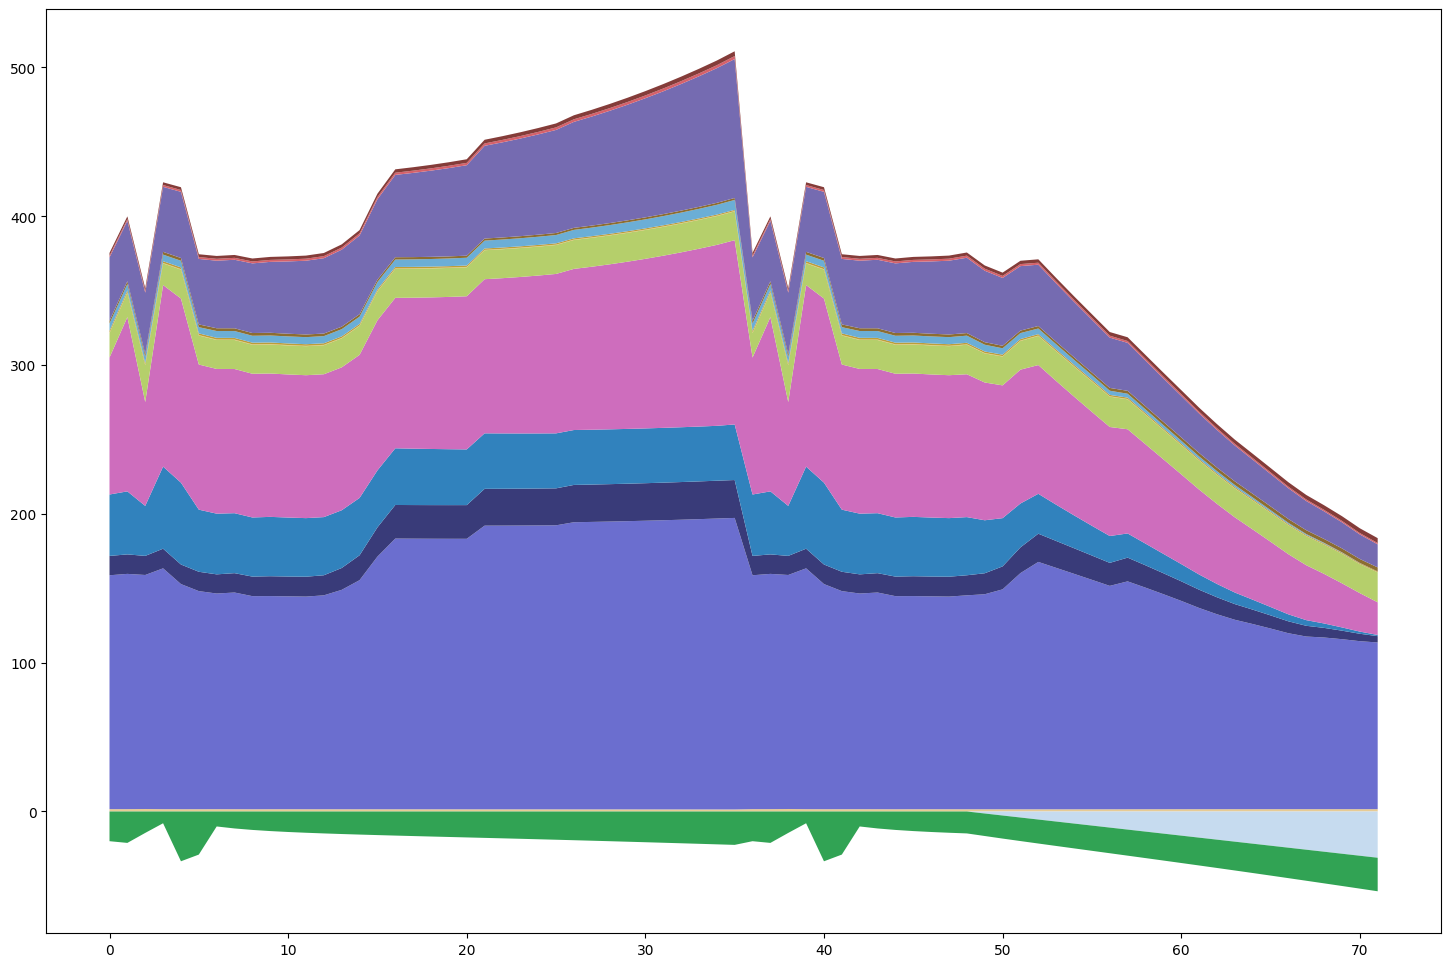

In [555]:
svp.plot_emissions_stack(
    df_out,
    matt,
)

In [556]:
ssp.generate_summary_files(None, export = True, );



##  Build the inventory

In [ ]:
path_read

In [988]:
# input paths
path_ssp_la = pathlib.Path("/Users/usuario/git/ssp_louisiana")
path_ssp_invtabs = path_ssp_la.joinpath("inventory_tables")
path_ssp_field_map = path_ssp_invtabs.joinpath("louisiana_historical_emissions_to_ssp_fields.csv")

# output paths
path_out_inv_cw_accounted = path_ssp_invtabs.joinpath("crosswalk_inventory_to_sisepeude_la_accounted.csv")
path_out_inv_cw_unaccounted = path_ssp_invtabs.joinpath("crosswalk_inventory_to_sisepeude_la_unaccounted.csv")
path_out_inv_trajectories_accounted = path_ssp_invtabs.joinpath("inventory_trajectories_accounted.csv")




##  GLOBAL VARIABLES

_FIELD_ACCOUNTED = "accounted"
_FIELD_CATEGORY_AGGREGATION = "aggregation_category"
_FIELD_GAS = "gas"
_FIELD_VARIABLE_FIELD = "variable_field"
_FIELD_VALUE = "emission_co2e_mt"



def aggregate_table(
    df: pd.DataFrame,
    fields_year: List[Union[str, int]],
    delim: str = "|",
) -> pd.DataFrame:
    """Aggregate each table and select only fields that are necessary
    """
    # set fields
    fields_group = [
        _FIELD_CATEGORY_AGGREGATION,
        _FIELD_GAS
    ]
    fields_agg = [_FIELD_VARIABLE_FIELD] + fields_year
    fields_ext = fields_group + fields_agg


    ##  ITERATE OVER DF GROUPINGS
    
    # group and initialize new output
    dfg = df[fields_ext].groupby(fields_group)
    df_out = []

    for i, df in dfg:
        # update the fields 
        fields_new = (
            delim.join(df[_FIELD_VARIABLE_FIELD].to_numpy(), )
            .split(delim, )
        )
        fields_new = delim.join(sorted(fields_new, ))
        
        # aggregate fields in the df
        df_new = df.iloc[0:1]
        df_new[_FIELD_VARIABLE_FIELD] = fields_new

        # sum data?
        if len(fields_year) > 0:
            vals_new = df[fields_year].sum(axis = 0, )
            df_new[fields_year] = [vals_new]
        
        # add to output dataframe
        df_out.append(df_new)

    df_out = sf._concat_df(df_out, )
    
    return df_out



def format_tables(
    df: pd.DataFrame,
    model_attributes: 'ModelAttributes',
    time_periods: 'TimePeriods',
    sit_gwp_ch4: float = 28.0,
    sit_gwp_n2o: float = 265.0,
) -> Tuple[pd.DataFrame]:
    """Generate decomposition tables

    
    """

    # split into accounted/unaccounted
    inds_accounted = (df[_FIELD_ACCOUNTED] == 1)
    df_accounted = df[inds_accounted]
    df_unaccounted = df[~inds_accounted]

    # get data fields
    fields_year = get_inv_years(df)


    ##  BUILD CROSSWALKS

    fields_agg_for_cw = [
        _FIELD_CATEGORY_AGGREGATION,
        _FIELD_GAS,
        _FIELD_VARIABLE_FIELD
    ]
    fields_cw_out = [_FIELD_ACCOUNTED] + fields_agg_for_cw
    
    # build the crosswalk index for accounted fields
    df_cw_accounted = aggregate_table(
        df_accounted[fields_agg_for_cw], 
        [],
    )
    df_cw_accounted[_FIELD_ACCOUNTED] = 1
    df_cw_accounted = df_cw_accounted[fields_cw_out]

    # build the crossasciiwalk index for unaccounted fields
    df_cw_unaccounted = aggregate_table(
        df_unaccounted[fields_agg_for_cw], 
        [],
    )
    df_cw_unaccounted[_FIELD_ACCOUNTED] = 0
    df_cw_unaccounted = df_cw_unaccounted[fields_cw_out]


    ##  BUILD DATASETS
    
    df_traj_accounted = aggregate_table(
        df_accounted,
        fields_year,
    )

    df_traj_unaccounted = aggregate_table(
        df_unaccounted, 
        fields_year,
    )


    # get these trajectories and covert
    df_traj_accounted = unwrap_trajectories(
        df_traj_accounted,
        fields_year,
        model_attributes,
        time_periods,
        dict_sit_gwp = {
            "co2": sit_gwp_ch4,
            "n2o": sit_gwp_n2o,
        }
    ) 


    # set output
    out = (
        df_cw_accounted,
        df_cw_unaccounted,
        df_traj_accounted
    )
    
    return out



def get_inv_years(
    df: pd.DataFrame,
) -> List[int]:
    """Get the field years from the map data frame
    """
    years = [x for x in df.columns if sf.isnumber(x) or str(x).isnumeric()]
    
    return years



def unwrap_trajectories(
    df: pd.DataFrame,
    fields_year: List[str],
    model_attributes: 'ModelAttributes',
    time_periods: 'TimePeriods',
    dict_sit_gwp: Dict[str, float] = {},
) -> pd.DataFrame:
    """Move trajectories from wide to long and drop variable_field

    dict_sit_gwp : Dict[str, float]
        Dictionary mapping SIT GWP for gasses to the value
    """

    df_out = df.copy()

    # fix any issues with GWP
    for gas, gwp_from_sit in dict_sit_gwp.items():

        # find gas index
        w = np.where(df_out[_FIELD_GAS].to_numpy() == gas)[0]
        gwp_from_ssp = model_attributes.get_gwp(gas, )
        
        # move on?
        skip = len(w) == 0
        skip |= gwp_from_ssp is None
        if skip: continue

        # adjust
        df_out.loc[w, fields_year] *= gwp_from_ssp/gwp_from_sit

    
    # melt to long
    df_out = (
        df
        .drop(columns = _FIELD_VARIABLE_FIELD, )
        .melt(
            id_vars = [
                _FIELD_CATEGORY_AGGREGATION,
                _FIELD_GAS
            ],
            value_name = _FIELD_VALUE,
            value_vars = fields_year,
            var_name = time_periods.field_year,
        )
        .sort_values(
            by = [
                _FIELD_CATEGORY_AGGREGATION,
                _FIELD_GAS,
                time_periods.field_year,
            ]
        )
        .reset_index(drop = True, )
    )

    # make sure years are integers
    df_out[time_periods.field_year] = df_out[time_periods.field_year].astype(int)
    
    return df_out






df_inv_map = pd.read_csv(path_ssp_field_map)
df_cw_accounted, df_cw_unaccounted, df_trajectories = format_tables(
    df_inv_map,
    matt,
    time_periods, 
)

# write tables
sf._write_csv(df_cw_accounted, path_out_inv_cw_accounted, )
sf._write_csv(df_cw_unaccounted, path_out_inv_cw_unaccounted, )
sf._write_csv(df_trajectories, path_out_inv_trajectories_accounted, )





True

In [1000]:
df_out["primary_id"].unique()
df_out_cloud = pd.read_csv("/Users/usuario/Documents/aws_sisepuede/data.csv")

In [1005]:
df_out[[x for x in df_out.columns if x.startswith("prod_enfu_fuel_")]].iloc[0:36]

df_out["primary_id"].unique()

array([368368, 438438])

In [818]:
df_tmp = pd.read_csv("/Users/usuario/Documents/aws_sisepuede/sisepuede_results_IDE_2025-10-14t00;19;25.886881_cleaned.csv")
df_end = df_tmp[df_tmp[ssp.key_time_period].isin([35])]





In [842]:
df_end = df_tmp[df_tmp[ssp.key_time_period].isin([35])]
#df_end["emission_co2e_co2_entc_processing_and_refinement_fp_petroleum_refinement"].unique()
#[x for x in df_end.columns if x.startswith("emission_co2e_co2_entc_")]
df_out["emission_co2e_co2_entc_nbmass_processing_and_refinement_fp_petroleum_refinement"]
df_out[[x for x in df_end.columns if x.startswith("emission_co2e_co2_entc_") and ("_processing_and_refinement" in x)]]

ks = [x for x in df_end.columns if x.startswith("emission_co2e_co2_entc_") and ("_processing_and_refinement" in x)]




In [849]:
df_out[df_out["time_period"].isin([35])][["emission_co2e_subsector_total_entc"]].sum(axis = 1)
112.010228/195.919991

0.5717141340620008

In [814]:
df_out[[x for x in df_out.columns if "emission_co2e_co2_entc_nbmass_processing_and_refinement_fp_hydrogen_" in x]].iloc[5]
#df_out[["emission_co2e_co2_entc_nbmass_processing_and_refinement_fp_"]]
",".join([x for x in df_out.columns if "emission_co2e_co2_entc_nbmass_processing_and_refinement_fp_hydrogen_" in x])

'emission_co2e_co2_entc_nbmass_processing_and_refinement_fp_hydrogen_electrolysis,emission_co2e_co2_entc_nbmass_processing_and_refinement_fp_hydrogen_gasification,emission_co2e_co2_entc_nbmass_processing_and_refinement_fp_hydrogen_reformation,emission_co2e_co2_entc_nbmass_processing_and_refinement_fp_hydrogen_reformation_ccs'

In [852]:
matt.get_gwp("n2o")

273.0

In [798]:
# df_input
import sisepuede.models.afolu as mafl
import sisepuede.models.circular_economy as ce
importlib.reload(ce)

model_afolu = mafl.AFOLU(matt, )
model_ce = ce.CircularEconomy(matt, )

df_out_afolu = model_afolu(df_input,)
df_input_ce = pd.merge(df_input, df_out_afolu, )
#sdf_input_ce["physparam_waso_k_food"] = 0.0
df_out_ce = model_ce(df_input_ce,)


In [799]:
##### matt.get_attribute_table("Solid Waste").key_values
df_out_ce[[x for x in df_out_ce.columns if ("emission_co2e_" in x) and ("landfill" in x)]].sum(axis = 1)


0     0.000489
1     0.000463
2     0.000440
3     0.000419
4     0.000400
5     0.000383
6     0.000369
7     0.000355
8     0.000344
9     0.000333
10    0.000324
11    0.000316
12    0.000308
13    0.000302
14    0.000297
15    0.000292
16    0.000288
17    0.000284
18    0.000281
19    0.000278
20    0.000276
21    0.000274
22    0.000273
23    0.000271
24    0.000271
25    0.000270
26    0.000270
27    0.000269
28    0.000269
29    0.000269
30    0.000270
31    0.000270
32    0.000271
33    0.000272
34    0.000272
35    0.000273
dtype: float64

In [689]:
model_ce.array_waso_emissions_ch4_landfill[:, 1]
matt.get_variable(model_ce.modvar_waso_waste_total_produced)#"Fraction of Non-Recycled Solid Waste Landfilled")

ModelVariable: Total Solid Waste Produced
Fields:
	qty_waso_total_chemical_industrial_produced_tonne
	qty_waso_total_food_produced_tonne
	qty_waso_total_glass_produced_tonne
	qty_waso_total_metal_produced_tonne
	qty_waso_total_nappies_produced_tonne
	qty_waso_total_other_produced_tonne
	qty_waso_total_paper_produced_tonne
	qty_waso_total_plastic_produced_tonne
	qty_waso_total_rubber_leather_produced_tonne
	qty_waso_total_sludge_produced_tonne
	qty_waso_total_textiles_produced_tonne
	qty_waso_total_wood_produced_tonne
	qty_waso_total_yard_produced_tonne

In [721]:
df_out_ce[[x for x in df_out_ce.columns if "emission_co2e_ch4_waso_landfilled_" in x]]#.sum(axis = 1)
#df_out_ce[[x for x in df_out_ce.columns if "qty_waso_landfilled_" in x]]



,emission_co2e_ch4_waso_landfilled_chemical_industrial,emission_co2e_ch4_waso_landfilled_food,emission_co2e_ch4_waso_landfilled_glass,emission_co2e_ch4_waso_landfilled_metal,emission_co2e_ch4_waso_landfilled_nappies,emission_co2e_ch4_waso_landfilled_other,emission_co2e_ch4_waso_landfilled_paper,emission_co2e_ch4_waso_landfilled_plastic,emission_co2e_ch4_waso_landfilled_rubber_leather,emission_co2e_ch4_waso_landfilled_sludge,emission_co2e_ch4_waso_landfilled_textiles,emission_co2e_ch4_waso_landfilled_wood,emission_co2e_ch4_waso_landfilled_yard
0,0.005307,0.000282,0.0,0.0,0.000009,0.0,0.000168,0.0,0.0,0.000057,0.000004,0.000108,0.000181
1,0.005726,0.000298,0.0,0.0,0.000010,0.0,0.000184,0.0,0.0,0.000061,0.000004,0.000119,0.000196
2,0.006092,0.000311,0.0,0.0,0.000011,0.0,0.000199,0.0,0.0,0.000063,0.000005,0.000129,0.000208
3,0.006437,0.000322,0.0,0.0,0.000011,0.0,0.000213,0.0,0.0,0.000066,0.000005,0.000140,0.000220
4,0.006774,0.000332,0.0,0.0,0.000012,0.0,0.000227,0.0,0.0,0.000068,0.000005,0.000151,0.000231
5,0.007093,0.000341,0.0,0.0,0.000012,0.0,0.000240,0.0,0.0,0.000070,0.000006,0.000161,0.000242
6,0.007398,0.000349,0.0,0.0,0.000013,0.0,0.000253,0.0,0.0,0.000071,0.000006,0.000171,0.000251
7,0.007689,0.000356,0.0,0.0,0.000013,0.0,0.000265,0.0,0.0,0.000073,0.000006,0.000182,0.000260
8,0.007968,0.000363,0.0,0.0,0.000014,0.0,0.000277,0.0,0.0,0.000074,0.000007,0.000192,0.000269
9,0.008237,0.000368,0.0,0.0,0.000014,0.0,0.000289,0.0,0.0,0.000076,0.000007,0.000202,0.000277


In [669]:

df_example["physparam_waso_k_food"]

0     0.183
1     0.183
2     0.183
3     0.183
4     0.183
5     0.183
6     0.183
7     0.183
8     0.183
9     0.183
10    0.183
11    0.183
12    0.183
13    0.183
14    0.183
15    0.183
16    0.183
17    0.183
18    0.183
19    0.183
20    0.183
21    0.183
22    0.183
23    0.183
24    0.183
25    0.183
26    0.183
27    0.183
28    0.183
29    0.183
30    0.183
31    0.183
32    0.183
33    0.183
34    0.183
35    0.183
Name: physparam_waso_k_food, dtype: float64

In [667]:
df_example = examples("input_data_frame").copy()

In [634]:
df_read = pd.read_csv("/Users/usuario/Downloads/sisepuede_results_sisepuede_run_2025-10-19T21;53;43.379520/sisepuede_results_sisepuede_run_2025-10-19T21;53;43.379520_WIDE_INPUTS_OUTPUTS.csv")



# TEMP
field_paper = "prodinit_ippu_paper_tonne"
field_wood = "prodinit_ippu_wood_tonne"
fields = [field_paper, field_wood]

df_read[field_paper] /= 32
df_read[field_wood] /= 6



(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

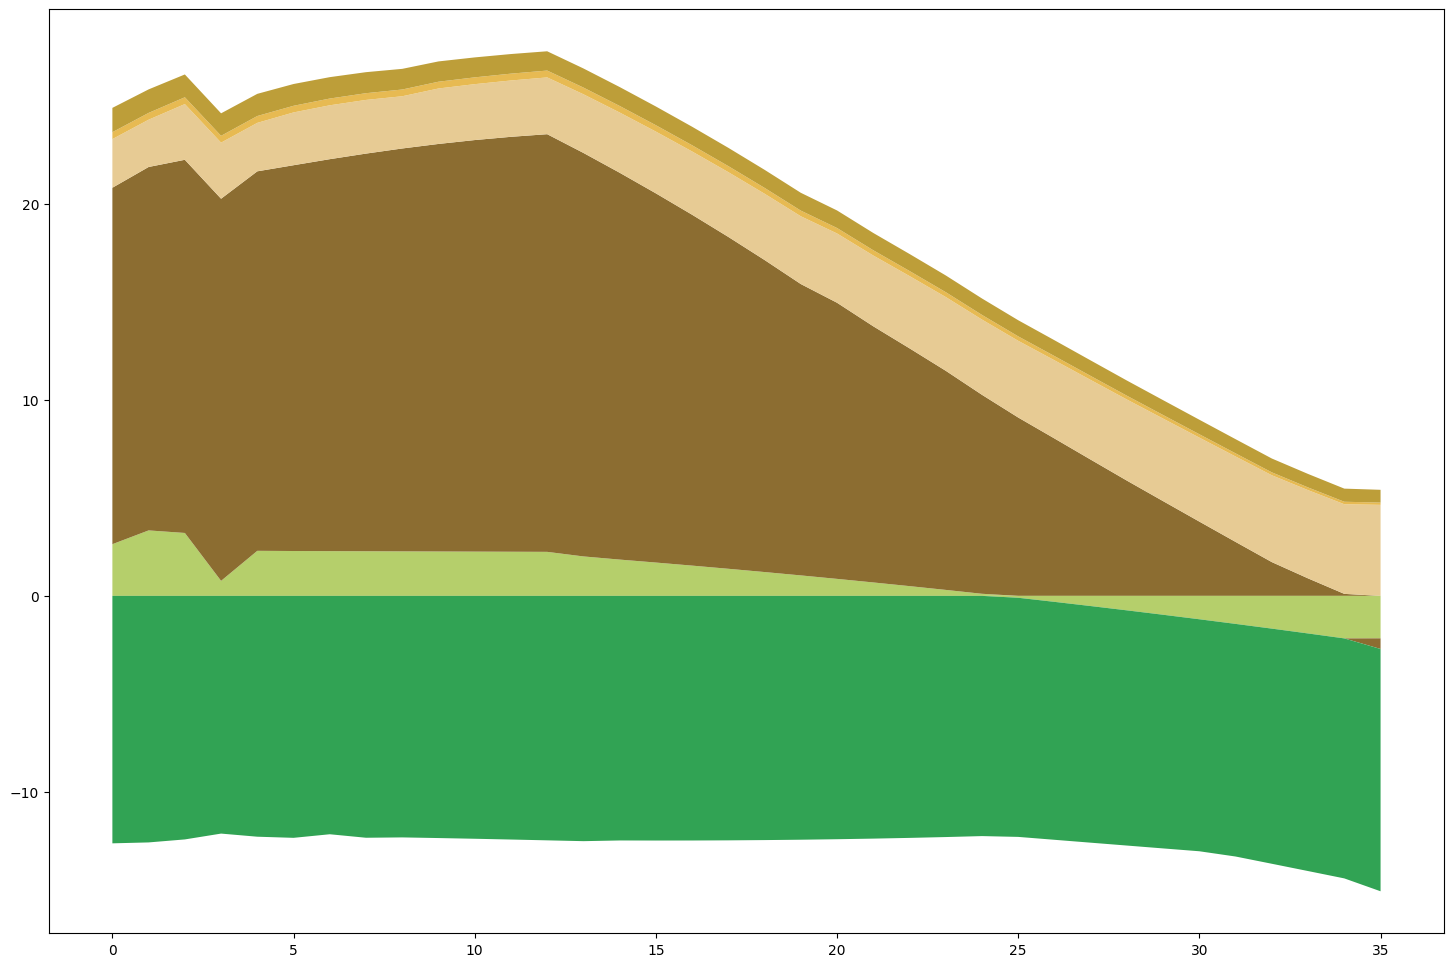

In [635]:
df_check = df_read[df_read["primary_id"].isin([76076])].copy()

df_out = models(
    df_check,
    include_electricity_in_energy = False,
)

svp.plot_emissions_stack(
    df_out,
    matt,
)


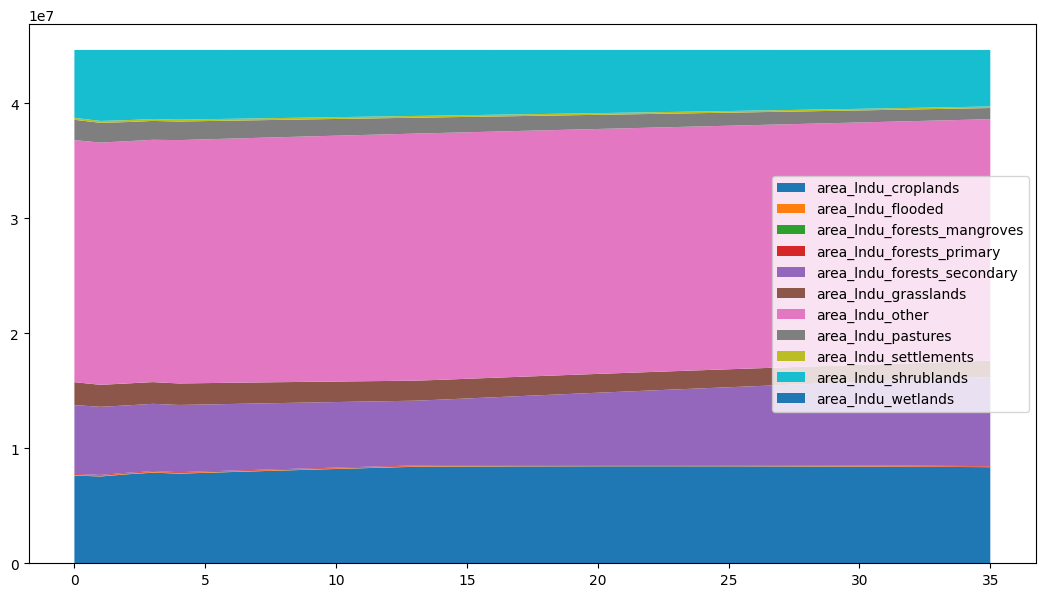

In [610]:
modvar = matt.get_variable("Land Use Area")
df_plot = modvar.get_from_dataframe(df_read, fields_additional = ["primary_id"], )



fig, ax = plt.subplots(figsize = (13, 7))
svp.spu.plot_stack(
    df_plot[df_plot["primary_id"].isin([76076])],
    modvar.fields,
    figtuple = (fig, ax, ), 
)

ax.legend()

<Axes: >

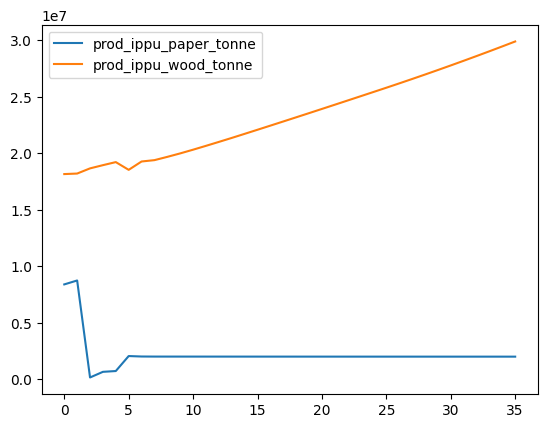

In [623]:
df_check = df_read[df_read["primary_id"].isin([0])]
df_check[
    # [x for x in df_check.columns if x.startswith("emission_co2e_co2_frst")]
    ["prod_ippu_paper_tonne", "prod_ippu_wood_tonne"]
].plot()


(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

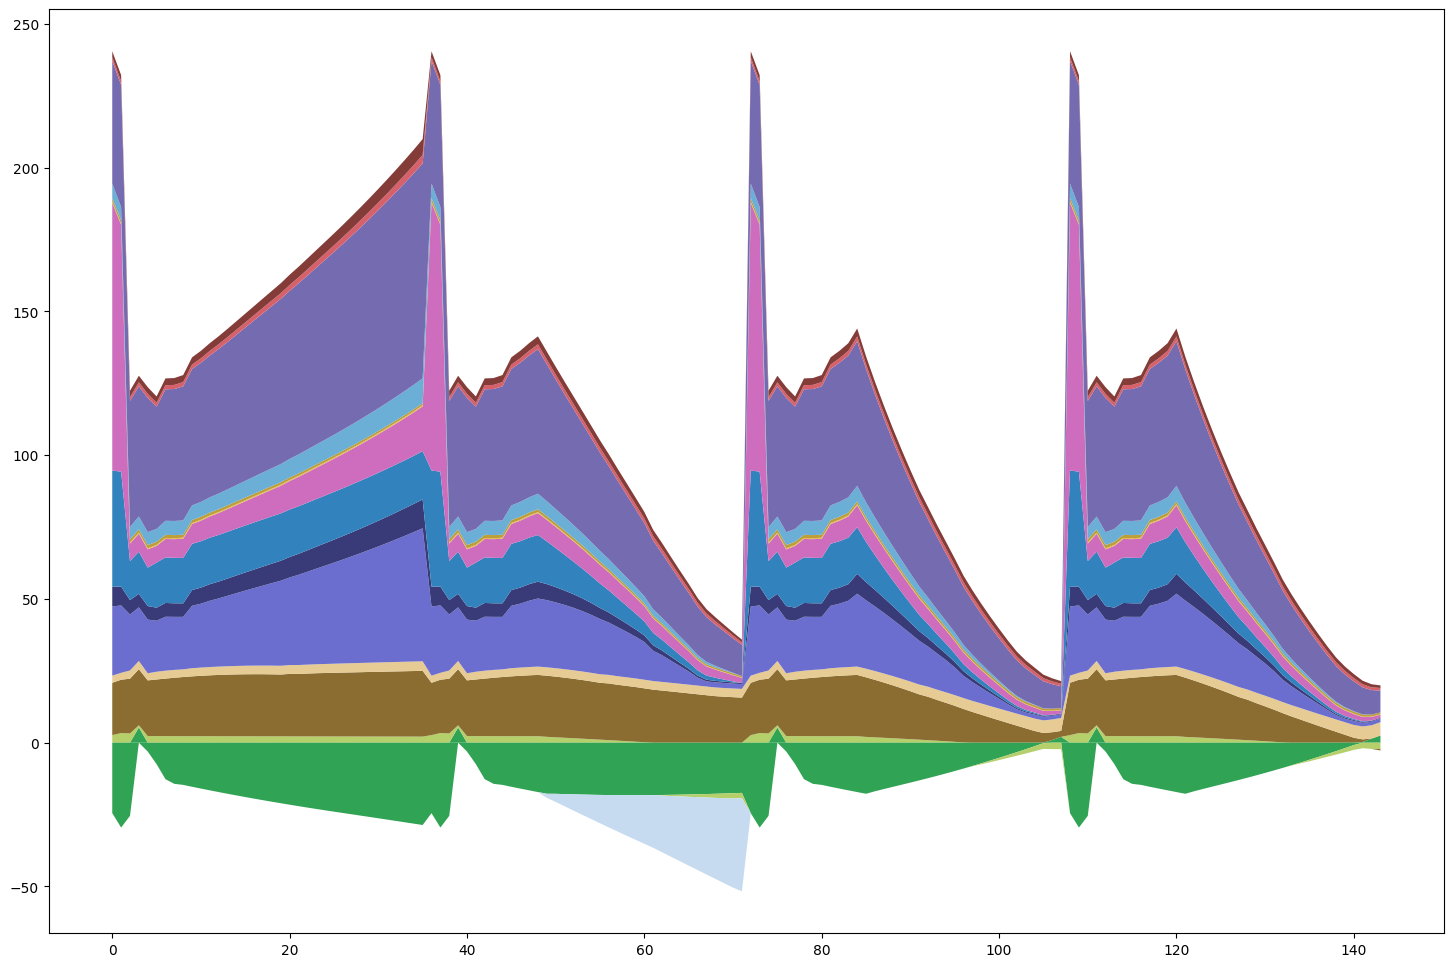

In [603]:
svp.plot_emissions_stack(
    df_read,
    matt,
)

In [594]:
flds = [x for x in df_out.columns if ("energy_demand_enfu_subsector_total_pj_entc" in x)]
flds = [x for x in flds if ("_crude" not in x) and ("_nuclear" not in x)]
df_out[flds].iloc[0].sum()-3640

np.float64(1901.3813435736474)

In [600]:
[x for x in df_out.columns if ("prod" in x) and ("enfu" in x)]
[x for x in df_out.columns if ("prod" in x) and ("entc" in x)]

#df_out["prod_enfu_fuel_natural_gas_liquid_pj"]
df_out[[
    x for x in df_out.columns if ("emission_co2e" in x) and ("waso" in x)
]].iloc[0]


emission_co2e_ch4_waso_biogas_food                       0.000047
emission_co2e_ch4_waso_biogas_sludge                     0.000065
emission_co2e_ch4_waso_biogas_yard                       0.000008
emission_co2e_ch4_waso_compost_food                      0.008453
emission_co2e_ch4_waso_compost_sludge                    0.000588
emission_co2e_ch4_waso_compost_yard                      0.001536
emission_co2e_ch4_waso_incineration                      0.045037
emission_co2e_ch4_waso_landfilled_chemical_industrial    0.005307
emission_co2e_ch4_waso_landfilled_food                   0.001384
emission_co2e_ch4_waso_landfilled_glass                  0.000000
emission_co2e_ch4_waso_landfilled_metal                  0.000000
emission_co2e_ch4_waso_landfilled_nappies                0.000009
emission_co2e_ch4_waso_landfilled_other                  0.000000
emission_co2e_ch4_waso_landfilled_paper                  0.000168
emission_co2e_ch4_waso_landfilled_plastic                0.000000
emission_c

In [554]:
df_in = ssp.read_input(None)
df_out = ssp.read_output(None)

(<Figure size 1200x700 with 1 Axes>, <Axes: >)

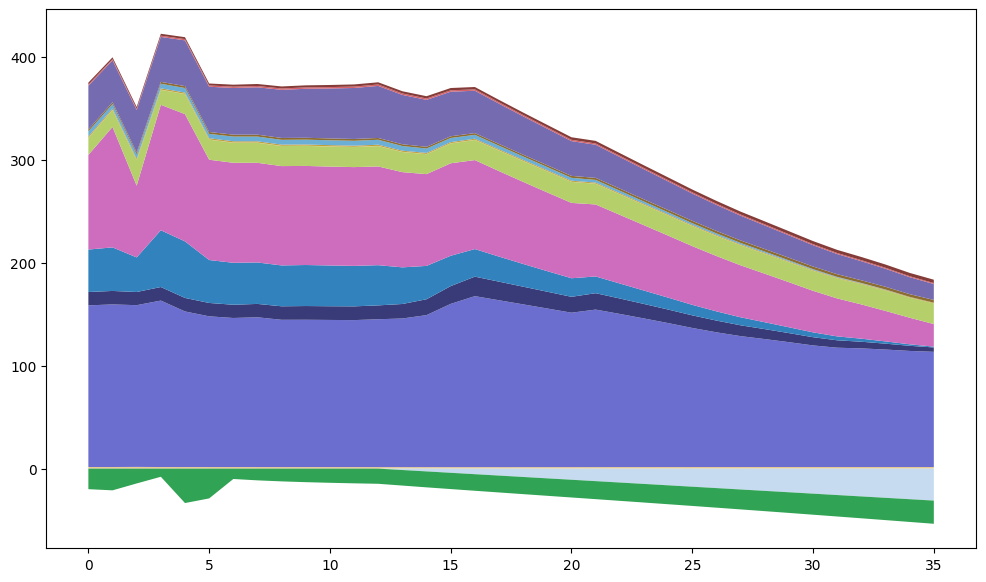

In [264]:
primaries = sorted(df_out[ssp.key_primary].unique())

fig, ax = plt.subplots(figsize = (12, 7))
svp.plot_emissions_stack(
    df_out[
        df_out[ssp.key_primary].isin([primaries[3]])
    ],
    matt,
    figtuple = (fig, ax),
    
)

In [283]:
df_out[
    df_out["primary_id"].isin([368368])
].to_csv("/Users/usuario/Desktop/tmp.csv", index = None, )

<Axes: >

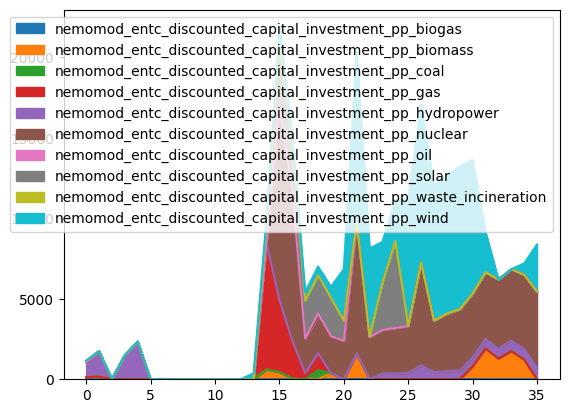

In [272]:
df_check = df_out[
    df_out[ssp.key_primary].isin([primaries[5]])
]

modvar = matt.get_variable("NemoMod Discounted Capital Investment")
df_plot = modvar.get_from_dataframe(df_check)
df_plot = df_plot[[x for x in df_plot.columns if df_plot[x].max() > 0]]

df_plot.plot.area()




In [598]:
models.model_enerprod.julia_main.VERSION

v"1.11.5"

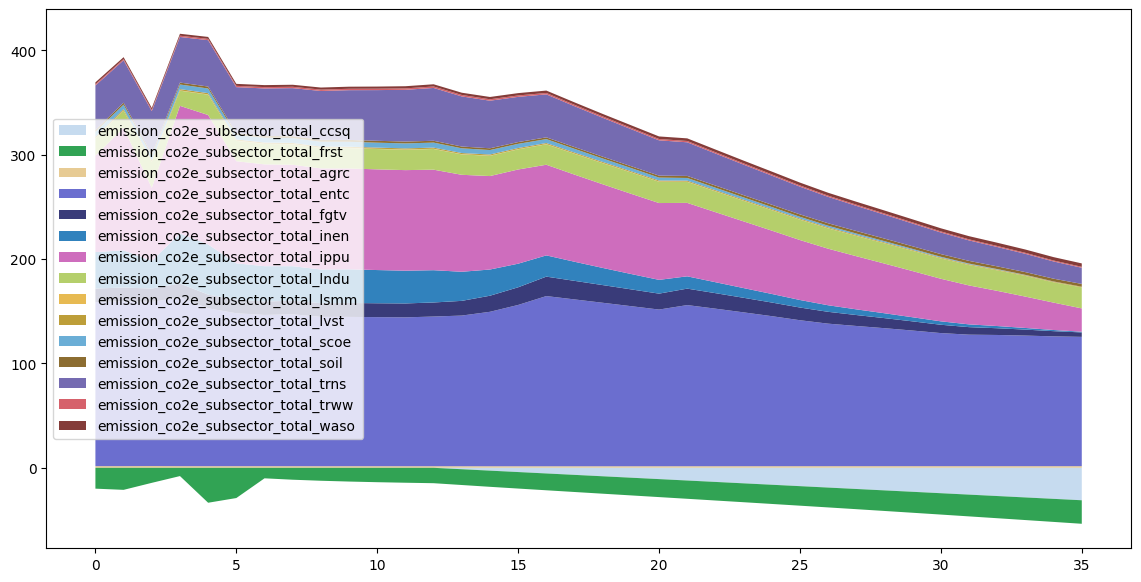

In [566]:
fig, ax = plt.subplots(figsize = (14, 7))

svp.plot_emissions_stack(
    df_out[
        df_out[ssp.key_primary].isin([70070])#405329])
    ],
    matt,
    figtuple = (fig, ax),
)

ax.legend()

2025-09-01 20:22:44,662 - INFO - Running AFOLU model
2025-09-01 20:22:44,959 - INFO - AFOLU model run successfully completed
2025-09-01 20:22:44,960 - INFO - Running CircularEconomy model
2025-09-01 20:22:44,984 - INFO - CircularEconomy model run successfully completed
2025-09-01 20:22:44,985 - INFO - Running IPPU model
2025-09-01 20:22:45,025 - INFO - IPPU model run successfully completed
2025-09-01 20:22:45,025 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-09-01 20:22:45,036 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-09-01 20:22:45,083 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-09-01 20:22:45,083 - INFO - Running Energy (Fugitive Emissions)
2025-09-01 20:22:45,096 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-09-01 20:22:45,096 - INFO - Appe

<Axes: >

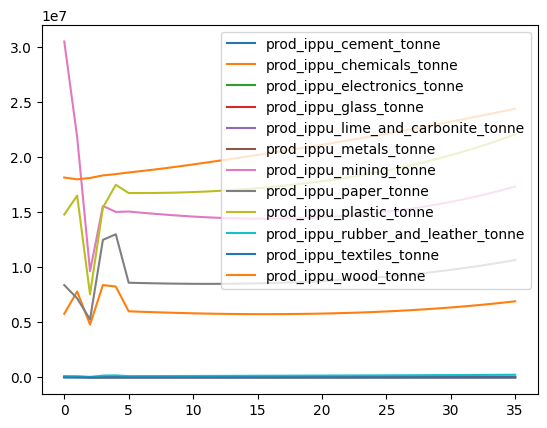

In [77]:
df_temp = ssp.models.project(
    df_0,
    include_electricity_in_energy = False,
)

modvar.get_from_dataframe(
    df_temp
).plot()

<Axes: >

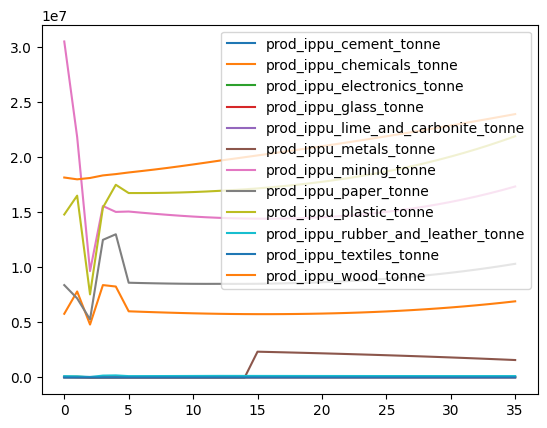

In [600]:
modvar = matt.get_variable("Industrial Production")
modvar.get_from_dataframe(
    df_out[
        df_out[ssp.key_primary].isin([70070])#405329])
    ]
).plot()

In [202]:
df_tmp = pd.read_csv("/Users/usuario/Documents/aws_sisepuede/tmp_data.csv")
cols_ordered = list(df_tmp.columns)

In [204]:
(
    df_out[
        df_out["primary_id"].isin([0])
    ][cols_ordered]
    .reset_index(drop = True, )
    .to_csv(
        "/Users/usuario/Documents/aws_sisepuede/upload_output.csv",
        index = None,
        encoding = "UTF-8",
    )
)

In [225]:
strategies.attribute_table.table.iloc[-14:]

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
69,6003,PFLO:ALL_WITH_ENFU_EXPORT_INCREASE,All Actions without decreasing exports or dema...,All actions (unique by transformer) with incre...,TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_LOSSES_SUPPLY...,0
70,6004,PFLO:ALL_LA_ACTIONS,All Louisiana Actions,All actions evaluated in the Louisiana context,TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_LOSSES_SUPPLY...,0
71,6005,PFLO:ALL_LA_ACTIONS_MEDIUM_INTENSITY,All Louisiana Actions at medium (approx 50%) i...,"Includes all actions evaluate in LEAP, but wit...",TX:AGRC:DEC_CH4_RICE_MIDINTENS|TX:AGRC:DEC_LOS...,0
72,6006,PFLO:ALL_LA_ACTIONS_LC,All Louisiana Actions with Least Cost Solution...,All actions evaluated in the Louisiana context...,TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_LOSSES_SUPPLY...,0
73,6007,PFLO:ALL_LA_ACTIONS_LC_MEDIUM_INTENSITY,All Louisiana Actions with Least Cost Solution...,Includes all actions evaluate in LEAP except f...,TX:AGRC:DEC_CH4_RICE_MIDINTENS|TX:AGRC:DEC_LOS...,0
74,6008,PFLO:TWI_ELECTRIC_POWER_95,TWI energy Subsector Electric Power 95,Defined by TWI 20250814 - TWI energy Subsector...,TX:ENTC:DEC_LOSSES|TX:ENTC:TARGET_RENEWABLE_ELEC,0
75,6009,PFLO:TWI_ELECTRIC_POWER_LC,TWI energy Subsector Electric Power LC,Defined by TWI 20250814 - TWI energy Subsector...,TX:ENTC:LEAST_COST_SOLUTION,0
76,6010,PFLO:TWI_ELECTRIC_POWER_EFFICIENCY,TWI energy Subsector Electric Power Efficiency,Defined by TWI 20250814 - TWI energy Subsector...,TX:ENTC:DEC_LOSSES,0
77,6011,PFLO:TWI_INDUSTRY,TWI energy Subsector Industry,Defined by TWI 20250814 - TWI energy Subsector...,TX:CCSQ:INC_CAPTURE|TX:ENTC:TARGET_CLEAN_HYDRO...,0
78,6012,PFLO:TWI_INDUSTRIAL_EFFICIENCY,TWI energy Subsector Industrial Efficiency,Defined by TWI 20250814 - TWI energy Subsector...,TX:INEN:INC_EFFICIENCY_ENERGY|TX:INEN:INC_EFFI...,0


In [222]:
ssp.odpt_primary.get_indexing_dataframe(df_out["primary_id"].unique())

,primary_id,design_id,strategy_id,future_id
0,0,0,0,0
1,70070,0,6004,0
2,71071,0,6005,0
3,72072,0,6006,0
4,73073,0,6007,0
5,74074,0,6008,0
6,75075,0,6009,0
7,76076,0,6010,0
8,77077,0,6011,0
9,78078,0,6012,0


In [357]:

"""flds = [
    x for x in df_tmp.columns 
    if True
    and ("frac_trns" in x)
    and ("water_borne" in x)
]
df_tmp[flds].sum(axis = 1)
"""


df_tmp0 = pd.read_csv("/Users/usuario/Downloads/Var_SSP_ENERGIA_21.csv")
df_tmp1 = pd.read_csv("/Users/usuario/Downloads/Var_SSP_AFOLU_2.csv")
df_tmp2 = pd.read_csv("/Users/usuario/Downloads/Var_SSP_Desechos_2.csv")
df_tmp3 = pd.read_csv("/Users/usuario/Downloads/Var_SSP_PIUP_2.csv")
df_tmp4 = pd.read_csv("/Users/usuario/Downloads/Var_SSP_Socie_2.csv")

df = pd.concat(
    [
        #df_tmp0,
        df_tmp1,
        df_tmp2, 
        df_tmp3,
        df_tmp4
    ],
    axis = 1,
)

df_example = examples.input_data_frame.copy()
fields_missing = [x for x in df_example.columns if x not in df.columns]
df = pd.concat(
    [
        df_example[fields_missing],
        df
    ],
    axis = 1,
)









In [368]:
df_out2[[x for x in df_out2.columns if ("emission_co2e" in x) and ("ippu" in x)]].iloc[0:1].transpose().sort_values(by = 0)






,0
emission_co2e_c2f6_ippu_product_use_product_use_ods_other,0.000000
emission_co2e_cf4_ippu_product_use_product_use_ods_other,0.000000
emission_co2e_hfcs_ippu_production_metals,0.000000
emission_co2e_cf4_ippu_production_electronics,0.000000
emission_co2e_hfcs_ippu_production_electronics,0.000000
...,...
emission_co2e_pfcs_ippu_production_chemicals,282.847653
emission_co2e_hfcs_ippu_production_chemicals,305.412064
emission_co2e_c2f6_ippu_production_metals,3846.504212
emission_co2e_cf4_ippu_production_metals,8241.445476


In [391]:
# df[[x for x in df.columns if "lvst" in x and "_n" in x]].iloc[0]
# 0.2/(1000*matt.get_gwp("c2f6"))
# df_example["ef_ippu_tonne_cf4_per_tonne_production_metals"]

In [413]:
df_example[[x for x in df_example.columns if ("enfu" in x) and ("cost" in x)]].iloc[0]


cost_enfu_fuel_biofuels_usd_per_m3                      3.163583e+01
cost_enfu_fuel_biogas_usd_per_mmbtu                     2.200000e+01
cost_enfu_fuel_biomass_usd_per_tonne                    2.097800e+02
cost_enfu_fuel_coal_usd_per_tonne                       1.048892e+02
cost_enfu_fuel_coke_usd_per_tonne                       1.877075e+02
cost_enfu_fuel_crude_usd_per_m3                         3.673626e+02
cost_enfu_fuel_diesel_usd_per_m3                        1.432857e+03
cost_enfu_fuel_electricity_usd_per_mmbtu                7.550796e+01
cost_enfu_fuel_furnace_gas_usd_per_m3                   8.907000e+04
cost_enfu_fuel_gasoline_usd_per_m3                      1.788571e+03
cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_mmbtu    1.616651e+02
cost_enfu_fuel_hydrogen_usd_per_mmbtu                   1.044513e+02
cost_enfu_fuel_kerosene_usd_per_m3                      2.169214e+01
cost_enfu_fuel_natural_gas_usd_per_mmbtu                6.239752e+00
cost_enfu_fuel_nuclear_usd_per_ton

In [410]:
df_out2[[x for x in df_out.columns if ("metals" in x)]].iloc[0]


emission_co2e_c2f6_ippu_production_metals            3.846504e+03
emission_co2e_cf4_ippu_production_metals             8.241445e+03
emission_co2e_ch4_ippu_production_metals             3.029122e-03
emission_co2e_co2_ippu_production_metals             1.085707e+00
emission_co2e_hfcs_ippu_production_metals            0.000000e+00
emission_co2e_sf6_ippu_production_metals             0.000000e+00
gasrecovered_ippu_mt_co2_capture_metals              0.000000e+00
net_imports_change_ippu_recycled_metals_tonne        0.000000e+00
prod_ippu_metals_tonne                               1.551010e+06
qty_ippu_recycled_metals_used_in_production_tonne    1.425204e+03
Name: 0, dtype: float64

In [407]:
df_input["consumpinit_inen_energy_tj_per_mmm_gdp_other_product_manufacturing"]

0     1.017079
1     1.112163
2     1.132271
3     1.141771
4     1.144099
5     1.256018
6     1.256018
7     1.256018
8     1.256018
9     1.256018
10    1.256018
11    1.256018
12    1.256018
13    1.256018
14    1.256018
15    1.256018
16    1.256018
17    1.256018
18    1.256018
19    1.256018
20    1.256018
21    1.256018
22    1.256018
23    1.256018
24    1.256018
25    1.256018
26    1.256018
27    1.256018
28    1.256018
29    1.256018
30    1.256018
31    1.256018
32    1.256018
33    1.256018
34    1.256018
35    1.256018
Name: consumpinit_inen_energy_tj_per_mmm_gdp_other_product_manufacturing, dtype: float64

In [427]:
for k in [x for x in matt.all_variable_fields_output if ("enfu" in x)]:
    print(k)



energy_demand_enfu_subsector_total_pj_ccsq_fuel_biofuels
energy_demand_enfu_subsector_total_pj_ccsq_fuel_biogas
energy_demand_enfu_subsector_total_pj_ccsq_fuel_biomass
energy_demand_enfu_subsector_total_pj_ccsq_fuel_coal
energy_demand_enfu_subsector_total_pj_ccsq_fuel_coke
energy_demand_enfu_subsector_total_pj_ccsq_fuel_crude
energy_demand_enfu_subsector_total_pj_ccsq_fuel_diesel
energy_demand_enfu_subsector_total_pj_ccsq_fuel_electricity
energy_demand_enfu_subsector_total_pj_ccsq_fuel_furnace_gas
energy_demand_enfu_subsector_total_pj_ccsq_fuel_gasoline
energy_demand_enfu_subsector_total_pj_ccsq_fuel_geothermal
energy_demand_enfu_subsector_total_pj_ccsq_fuel_hydrocarbon_gas_liquids
energy_demand_enfu_subsector_total_pj_ccsq_fuel_hydrogen
energy_demand_enfu_subsector_total_pj_ccsq_fuel_kerosene
energy_demand_enfu_subsector_total_pj_ccsq_fuel_natural_gas
energy_demand_enfu_subsector_total_pj_ccsq_fuel_nuclear
energy_demand_enfu_subsector_total_pj_ccsq_fuel_ocean
energy_demand_enfu_subsec

2025-08-29 15:24:31,937 - INFO - Running AFOLU model
2025-08-29 15:24:32,254 - INFO - AFOLU model run successfully completed
2025-08-29 15:24:32,255 - INFO - Running CircularEconomy model
2025-08-29 15:24:32,292 - INFO - CircularEconomy model run successfully completed
2025-08-29 15:24:32,293 - INFO - Running IPPU model
2025-08-29 15:24:32,340 - INFO - IPPU model run successfully completed
2025-08-29 15:24:32,341 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-29 15:24:32,353 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-29 15:24:32,409 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-29 15:24:32,409 - INFO - Running Energy (Fugitive Emissions)
2025-08-29 15:24:32,425 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-08-29 15:24:32,425 - INFO - Appe

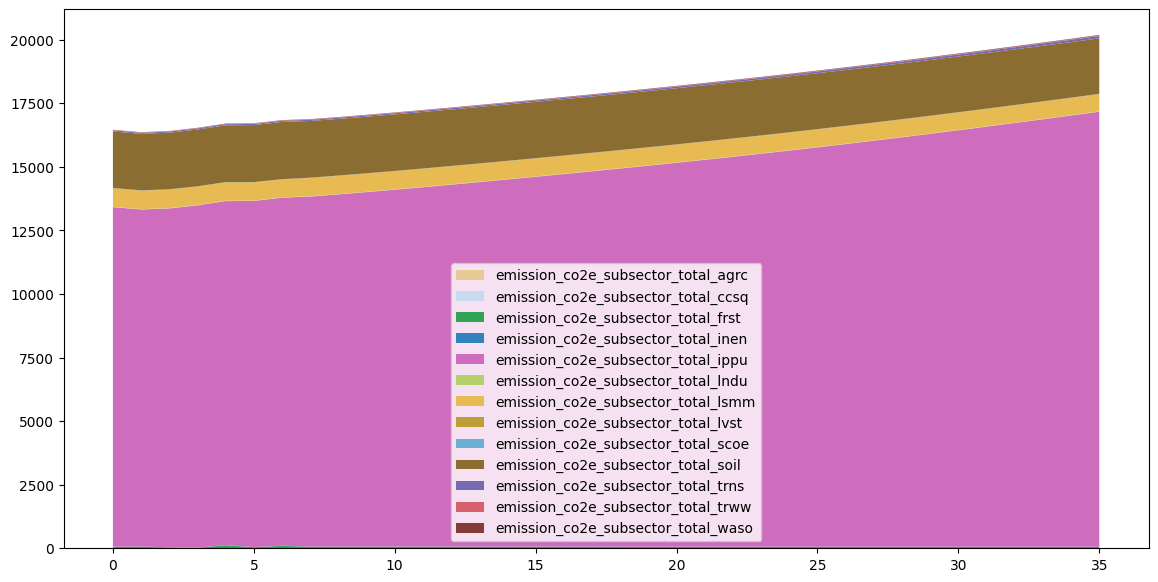

In [362]:
df_out2 = ssp.models.project(
    df,
    include_electricity_in_energy = False,
    
)

fig, ax = plt.subplots(figsize = (14, 7))

svp.plot_emissions_stack(
    df_out2,
    matt,
    figtuple = (fig, ax)
)

ax.legend()

In [356]:
import sisepuede.models.energy_consumption as ec

def get_all_trns_fields_from_subset(
    df_in: pd.DataFrame, 
    model_attributes: 'ModelAttributes',
) -> pd.DataFrame:
    """Using a DataFrame df_in that only has fuel mix fractions
        for SOME fuels for each transportation category, extract
        any remaining fuels.
    """
    df_transporation_frac = []
    model_enercons = ec.EnergyConsumption(model_attributes) #model_enercons
    modvars = model_enercons.modvars_trns_list_fuel_fraction
    attr_trns = model_attributes.get_attribute_table("Transportation")


    # order output fields
    fields_ext = []
    for cat in attr_trns.key_values:
    

        for modvar in modvars:
            modvar = matt.get_variable(modvar)
            if cat not in modvar.dict_category_keys.get("cat_transportation"):
                continue
    
            field = modvar.build_fields(category_restrictions = cat, )
            fields_ext.append(field)
    
        """
        max_dev = np.abs(vec - 1).max()
        if max_dev > 0.00000001:
            print(fields)
            print(f"{cat}:\t\t{vec.max()}")
        """

    
    for modvar in modvars:
        modvar = model_attributes.get_variable(modvar)
        try:
            out = model_attributes.extract_model_variable(
                df_in,
                modvar,
                all_cats_missing_val = 0.0,
                extraction_logic = "any_fill",
            )

        except:
            out = modvar.spawn_default_dataframe(
                length = df_in.shape[0],
            )

        df_transporation_frac.append(out, )

    df_transporation_frac = (
        pd.concat(
            df_transporation_frac,
            axis = 1
        )
        .get(fields_ext)
    )

    return df_transporation_frac

df_all_trns_frac_vars = = get_all_trns_fields_from_subset(
    df_tmp0, # YOUR ENERGY DATA
    matt,    # MODEL ATTRIBUTES
)

In [359]:
22

22

In [233]:
flds = matt.get_all_subsector_emission_total_fields()

<Axes: >

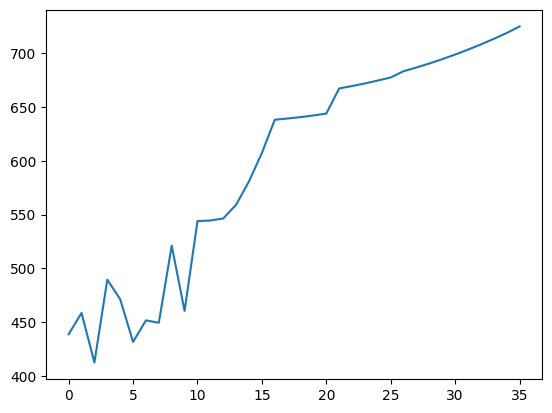

In [238]:

# df_out[df_out["primary_id"].isin([0])][flds].sum(axis = 1).plot()



(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

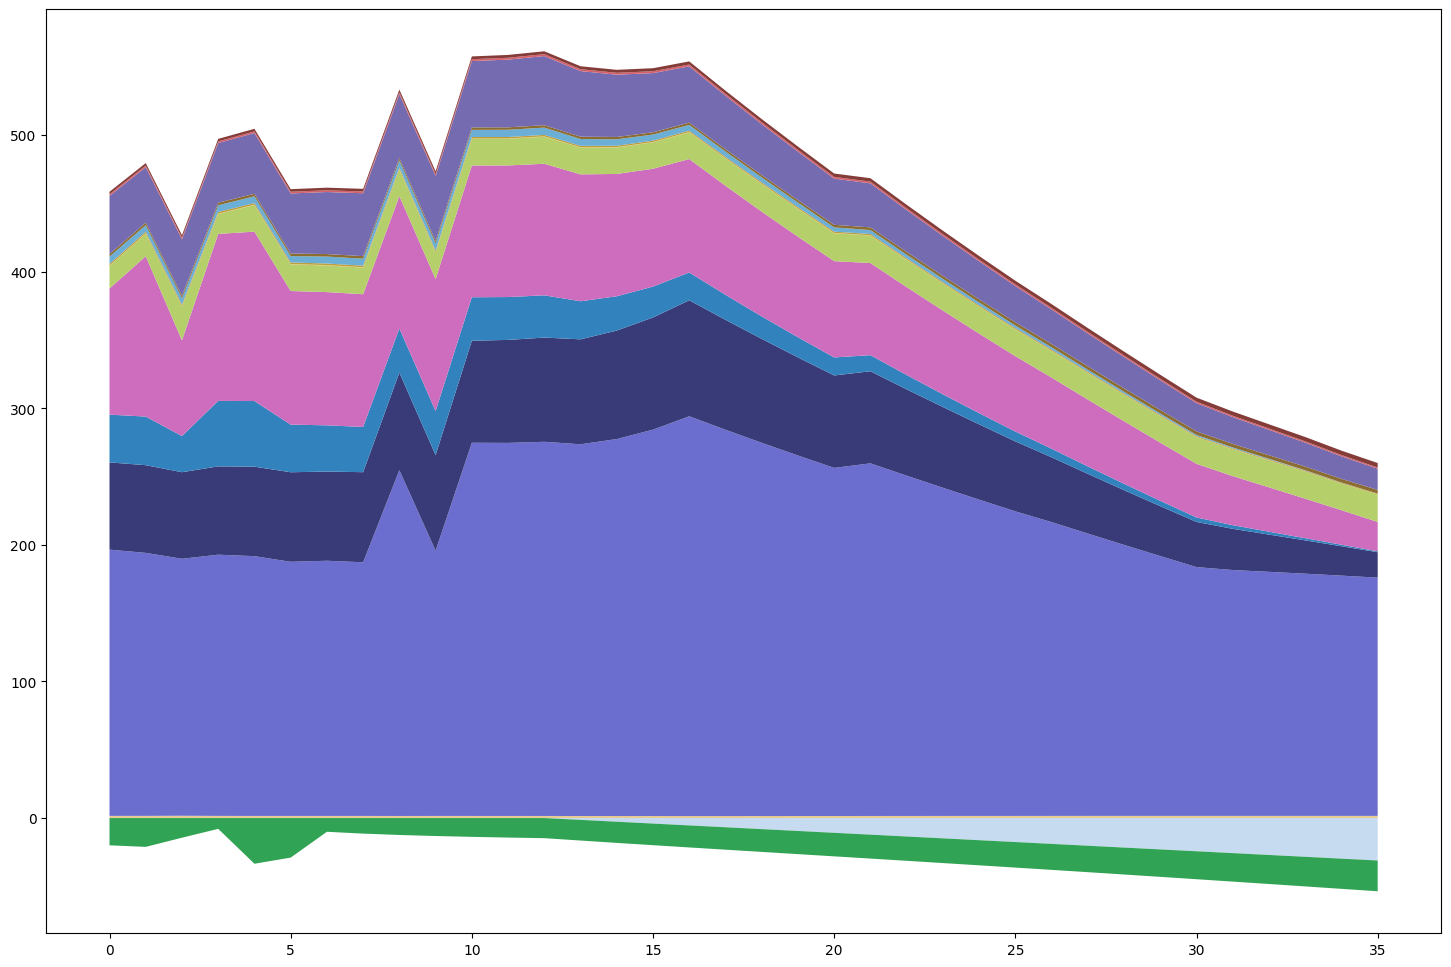

In [228]:
import sisepuede.plotting.plots as spp
svp.plot_emissions_stack(
    df_out[df_out["primary_id"].isin([70070])],
    matt,
)

# Finally, we can export a summary file

In [197]:
df_tmp.columns

False

In [199]:
df_in[cols_ordered]

,primary_id,region,time_period,area_gnrl_country_ha,area_lndu_infimum_croplands_ha,area_lndu_infimum_flooded_ha,area_lndu_infimum_forests_mangroves_ha,area_lndu_infimum_forests_primary_ha,area_lndu_infimum_forests_secondary_ha,area_lndu_infimum_grasslands_ha,...,yf_agrc_herbs_and_other_perennial_crops_tonne_ha,yf_agrc_nuts_tonne_ha,yf_agrc_other_annual_tonne_ha,yf_agrc_other_woody_perennial_tonne_ha,yf_agrc_pulses_tonne_ha,yf_agrc_rice_tonne_ha,yf_agrc_sugar_cane_tonne_ha,yf_agrc_tubers_tonne_ha,yf_agrc_vegetables_and_vines_tonne_ha,yf_lndu_supremum_pastures_tonne_per_ha
0,0,louisiana,0,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.059233,2.946800,6.177415,0.0,2.755621,8.636027,73.140598,37.547100,28.821448,92.81
1,0,louisiana,1,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.539800,3.455483,7.165802,0.0,3.259699,8.228317,71.163825,39.000100,29.765171,92.81
2,0,louisiana,2,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.161233,3.041817,11.119348,0.0,3.958685,8.302446,89.448975,39.119475,28.720595,92.81
3,0,louisiana,3,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.289167,3.375283,5.436126,0.0,4.167037,8.846059,90.190264,37.352525,29.482348,92.81
4,0,louisiana,4,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.337700,2.992183,6.177415,0.0,3.226093,7.882382,84.012849,38.551850,32.769776,92.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,80080,louisiana,31,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.023165,2.949341,6.319971,0.0,3.416092,8.422668,89.334930,39.935028,30.906144,92.81
428,80080,louisiana,32,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.023165,2.949341,6.319971,0.0,3.416092,8.422668,89.334930,39.935028,30.906144,92.81
429,80080,louisiana,33,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.023165,2.949341,6.319971,0.0,3.416092,8.422668,89.334930,39.935028,30.906144,92.81
430,80080,louisiana,34,13565900.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.023165,2.949341,6.319971,0.0,3.416092,8.422668,89.334930,39.935028,30.906144,92.81


# some temporary transformation work
- build tableau templates

In [1022]:
import sisepuede.visualization.tables as svt
importlib.reload(svt)

tableau_table = svt.LeversImplementationTable(strategies, )
dict_tables = tableau_table.build_table_for_strategy(6006)
df_tableau_table = tableau_table.build_table_for_strategies([6004, 6005, 6006])

df_tableau_table.to_csv(
    "/Users/usuario/Desktop/tableau_example_long_lever_table.csv",
    encoding = "UTF-8",
    index = None,
)